<a href="https://colab.research.google.com/github/DenisPushkin/DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DCGAN**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import skimage.transform
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import ast
print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3()

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = skimage.transform.resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=1, eps=1E-16):
	# enumerate splits of images/predictions
	scores = list()
	n_part = np.int(np.floor(images.shape[0] / n_split))
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset / 1.0
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
    #subset = tf.keras.applications.inception_v3.preprocess_input(subset)
		# predict p(y|x)
		p_yx = InceptionV3_model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg = np.mean(scores)
	return is_avg

96116736/96112376 [==============================] - 2s 0us/step


In [ ]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,:,np.newaxis]
x_train = x_train/127.5 - 1 #to [-1, 1] range
y_train = tf.keras.utils.to_categorical(y_train, num_classes=11)

print(x_train.shape)
print(y_train.shape)
y = y_train[y_train[:,10]==1]
print(y.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000, 11)
(0, 11)


In [ ]:
class OptimisticAdam:

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='optimistic_adam'):

        self.learning_rate = tf.constant(learning_rate, dtype=tf.float32)
        self.beta_1 = tf.constant(beta_1, dtype=tf.float32)
        self.beta_2 = tf.constant(beta_2, dtype=tf.float32)
        self.epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.m = {}
        self.v = {}
        self.lr_prev = {}
        self.t = {}
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if var.name not in self.t.keys():
                self.t[var.name] = 1
            else:
                self.t[var.name] += 1
            if var.name not in self.m.keys():
                self.m[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.m[var.name] = self.beta_1*self.m[var.name] + (1-self.beta_1)*grad
            if var.name not in self.v.keys():
                self.v[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.v[var.name] = self.beta_2*self.v[var.name] + (1-self.beta_2)*tf.math.multiply(grad,grad)
            m_head = self.m[var.name] / (1 - math.pow(self.beta_1, self.t[var.name]))
            v_head = self.v[var.name] / (1 - math.pow(self.beta_2, self.t[var.name]))
            lr_t = m_head / tf.sqrt(v_head + self.epsilon)
            if var.name not in self.lr_prev.keys():
                self.lr_prev[var.name] = lr_t

            var.assign_sub(2*self.learning_rate*lr_t)
            var.assign_add(self.learning_rate*self.lr_prev[var.name])

            self.lr_prev[var.name] = lr_t

class ExtraAdam(tf.keras.optimizers.Adam):
    """
    ExtraAdam optimizer is actually Adam optimizer, but depending of optimizer's type
    disc_backpropagation and gen_backpropagation functions of the model behave differently.
    They contain the following if-claus:
    
    if type(optimizer) == ExtraAdam:
        ...

    """
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='extra_adam'):
        super(ExtraAdam, self).__init__(learning_rate, beta_1, beta_2, epsilon)


In [ ]:
def get_generator():
    inputs = Input(shape = (128,))
    h = Dense(units = 4*4*256, activation = None, use_bias = False)(inputs)
    h = Reshape(target_shape=[4,4,256])(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides = (2,2), padding='same', use_bias = False)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding='same', use_bias = False)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding='same', activation='tanh')(h)
    outputs = h[:,2:-2,2:-2,:]
    generator = Model(inputs=inputs, outputs=outputs)
    return generator

def get_discriminator():
    discriminator = Sequential([
                                Input(shape=(28,28,1)),
                                Conv2D(64, (5,5), strides=(2,2), padding='same'),
                                LeakyReLU(0.2),
                                Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias = False),
                                BatchNormalization(),
                                LeakyReLU(0.2),
                                Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias = False),
                                BatchNormalization(),
                                LeakyReLU(0.2),
                                Flatten(),
                                Dense(11)
    ])
    return discriminator

generator = get_generator()
generator.summary()
discriminator = get_discriminator()
discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              524288    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_9 (Activation)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 128)         512 

In [ ]:
"""
#previous model

class DCGAN(Model):
    
    def __init__(self, generator, discriminator, x_train, y_train):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dimension = generator.input.shape[1]
        self.batch_size = 64
        self.dataset_generator = self.get_train_dataset(x_train, y_train)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
        self.losses_per_epoch = {'generator': [], 'discriminator': []}
        self.first_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.last_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.epoch = 0
        
    def get_train_dataset(self, x_train, y_train):
        x_train = tf.cast(x_train, dtype=tf.float32)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
        return train_dataset

    def sample_noise(self, batch_size = None):
        if batch_size == None:
            batch_size = self.batch_size
        return np.random.uniform(-1., 1., size = (batch_size, self.latent_dimension))

    @tf.function
    def disc_loss(self, data, labels, loss_fn):
        with tf.GradientTape() as tape:
            logits = self.discriminator(data)
            disc_loss = loss_fn(labels, logits)
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        return (disc_grads, disc_loss)

    @tf.function
    def gen_loss(self, noise, loss_fn):
        with tf.GradientTape() as tape:
            gen_data = self.generator(noise)
            logits = self.discriminator(gen_data)
            gen_loss = loss_fn(logits)
        gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        return (gen_grads, gen_loss, gen_data)
    
    def train(self, epochs):

        disc_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
        def gen_loss_fn(logits):
            p = tf.ones([self.batch_size]) - logits[:,-1]
            return tf.reduce_mean(tf.nn.relu(p) - p + tf.math.log(1+tf.exp(-tf.abs(p))))
        gen_loss_fn = gen_loss_fn

        for epoch in range(epochs):

            losses_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            first_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            last_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}

            for (real_data, real_labels) in self.dataset_generator:
                
                #x_data = tf.cast(x_data[0], tf.float32)
                noise = self.sample_noise()
                (gen_grads, gen_loss, gen_data) = self.gen_loss(noise, gen_loss_fn)
                gen_labels = tf.concat([tf.zeros([self.batch_size, 10]), tf.ones([self.batch_size, 1])], axis=1)
                data = tf.concat([real_data, gen_data], axis=0)
                labels = tf.concat([real_labels, gen_labels], axis=0)
                (disc_grads, disc_loss) = self.disc_loss(data, labels, disc_loss_fn)

                losses_per_batch['generator'](gen_loss)
                losses_per_batch['discriminator'](disc_loss)

                first_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[0])))
                last_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[-2])))
                first_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[0])))
                last_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[-2])))

                self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
                self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
            
            self.losses_per_epoch['generator'].append(losses_per_batch['generator'].result().numpy())
            self.losses_per_epoch['discriminator'].append(losses_per_batch['discriminator'].result().numpy())
            self.first_grads_mean_per_epoch['generator'].append(first_grads_mean_per_batch['generator'].result().numpy())
            self.last_grads_mean_per_epoch['generator'].append(last_grads_mean_per_batch['generator'].result().numpy())
            self.first_grads_mean_per_epoch['discriminator'].append(first_grads_mean_per_batch['discriminator'].result().numpy())
            self.last_grads_mean_per_epoch['discriminator'].append(last_grads_mean_per_batch['discriminator'].result().numpy())
            
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}".format(self.epoch+1,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1]))
            if (self.epoch%10 == 0):
                print('example of generated images after', self.epoch+1, 'epochs')
                images = self.generate(24)
                plt.figure(figsize = (18, 18))
                for i in range(24):
                    plt.subplot(4, 6, i+1)
                    plt.imshow(images[i,:,:,0], cmap='gray')
                plt.show()

                gen_path = '/content/drive/My Drive/Univ/Diploma/Saved models/DCGAN_with_labels/gen_{:03d}_epochs/gen_{:03d}_epochs'.format(self.epoch+1,
                                                                                                                              self.epoch+1)
                self.generator.save_weights(gen_path)
                
                disc_path = '/content/drive/My Drive/Univ/Diploma/Saved models/DCGAN_with_labels/disc_{:03d}_epochs/disc_{:03d}_epochs'.format(self.epoch+1,
                                                                                                                                  self.epoch+1)
                self.discriminator.save_weights(disc_path)          
                path = '/content/drive/My Drive/Univ/Diploma/Saved models/DCGAN_with_labels/train_info_{:03d}.txt'.format(self.epoch+1)
                f=open(path,'w')
                s1=str(self.losses_per_epoch['generator']) + '\n'
                f.write(s1)
                s1=str(self.losses_per_epoch['discriminator']) + '\n'
                f.write(s1)
                s1=str(self.first_grads_mean_per_epoch['generator']) + '\n'
                f.write(s1)
                s1=str(self.first_grads_mean_per_epoch['discriminator']) + '\n'
                f.write(s1)
                s1=str(self.last_grads_mean_per_epoch['generator']) + '\n'
                f.write(s1)
                s1=str(self.last_grads_mean_per_epoch['discriminator']) + '\n'
                f.write(s1)
                f.close()
            
            self.epoch += 1

        return (self.losses_per_epoch, self.first_grads_mean_per_epoch, self.last_grads_mean_per_epoch)

    def generate(self, num = 1):
        
        noise = self.sample_noise(batch_size = num)
        return self.generator.predict(noise)
"""

In [ ]:
class DCGAN(Model):
    
    def __init__(self, optimizer, x_train, y_train, batch_size=64, use_averaging=False,
                 path='/content/drive/My Drive/Univ/Final models/Saved models/DCGAN Adam/'):
        super(DCGAN, self).__init__()
        self.num_classes = 10
        self.discriminator = self.get_discriminator(num_classes=self.num_classes+1)
        self.latent_dimension = 128
        self.generator = self.get_generator(latent_dim = self.latent_dimension)
        self.use_averaging = use_averaging
        self.generator_avr = self.get_generator(latent_dim = self.latent_dimension) #saves average of variables
        self.batch_size = batch_size
        self.dataset_generator = self.get_train_dataset(x_train, y_train)
        #self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
        self.optimizer = optimizer
        self.losses_per_epoch = {'generator': [], 'discriminator': []}
        self.first_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.last_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.IS_per_epoch = [] #inception scores
        self.epoch = 0
        self.path = path
        self.train_steps_for_average = 0
        self.IS_for_avr_per_epoch = []

    def get_generator(self, latent_dim=128):
        inputs = Input(shape = (latent_dim,))
        h = Dense(units = 4*4*256, activation = None, use_bias = False)(inputs)
        h = Reshape(target_shape=[4,4,256])(h)
        h = BatchNormalization()(h)
        h = Activation('relu')(h)
        h = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides = (2,2), padding='same', use_bias = False)(h)
        h = BatchNormalization()(h)
        h = Activation('relu')(h)
        h = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding='same', use_bias = False)(h)
        h = BatchNormalization()(h)
        h = Activation('relu')(h)
        h = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding='same', activation='tanh')(h)
        outputs = h[:,2:-2,2:-2,:]
        generator = Model(inputs=inputs, outputs=outputs)
        return generator
    
    def get_discriminator(self,num_classes=11):
        discriminator = Sequential([
                                    Input(shape=(28,28,1)),
                                    Conv2D(64, (5,5), strides=(2,2), padding='same'),
                                    LeakyReLU(0.2),
                                    Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias = False),
                                    BatchNormalization(),
                                    LeakyReLU(0.2),
                                    Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias = False),
                                    BatchNormalization(),
                                    LeakyReLU(0.2),
                                    Flatten(),
                                    Dense(num_classes)
        ])
        return discriminator

    def get_train_dataset(self, x_train, y_train):
        x_train = tf.cast(x_train, dtype=tf.float32)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
        return train_dataset

    def sample_noise(self, batch_size = None):
        if batch_size == None:
            batch_size = self.batch_size
        return np.random.normal(size = (batch_size, self.latent_dimension))
    
    #@tf.function
    def disc_backpropagation(self, data, labels, loss_fn):
        if type(self.optimizer) == ExtraAdam:
            (disc_grads, disc_loss) = self.disc_backpropagation_for_extraadam(data, labels, loss_fn)
        else:
            with tf.GradientTape() as tape:
                logits = self.discriminator(data)
                disc_loss = loss_fn(labels, logits)
            disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        return (disc_grads, disc_loss)    
    
    def disc_backpropagation_for_extraadam(self, data, labels, loss_fn):
        indexes = np.arange(2 * self.batch_size)
        np.random.shuffle(indexes)
        data_2 = tf.gather(data, indexes[self.batch_size:])
        labels_2 = tf.gather(labels, indexes[self.batch_size:])
        data = tf.gather(data, indexes[:self.batch_size])
        labels = tf.gather(labels, indexes[:self.batch_size])
        with tf.GradientTape() as tape:
            logits = self.discriminator(data)
            disc_loss = loss_fn(labels, logits)
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        prev_trainable_variables = self.discriminator.trainable_variables
        self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        with tf.GradientTape() as tape:
            logits_2 = self.discriminator(data_2)
            disc_loss_2 = loss_fn(labels_2, logits_2)
        disc_grads_2 = tape.gradient(disc_loss_2, self.discriminator.trainable_variables)
        for (v,x) in zip(self.discriminator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(disc_grads_2, self.discriminator.trainable_variables))
        return (disc_grads, disc_loss)

    #@tf.function
    def gen_backpropagation(self, noise, loss_fn):
        if type(self.optimizer) == ExtraAdam:
            (gen_grads, gen_loss) = self.gen_backpropagation_for_extraadam(noise, loss_fn)
        else:
            with tf.GradientTape() as tape:
                gen_data = self.generator(noise)
                logits = self.discriminator(gen_data)
                gen_loss = loss_fn(logits)
            gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        return (gen_grads, gen_loss)
    
    def gen_backpropagation_for_extraadam(self, noise, loss_fn):
        indexes = np.arange(self.batch_size)
        noise_2 = tf.gather(noise, indexes[self.batch_size//2:])
        noise = tf.gather(noise, indexes[:self.batch_size//2])
        with tf.GradientTape() as tape:
            gen_data = self.generator(noise)
            logits = self.discriminator(gen_data)
            gen_loss = loss_fn(logits)
        gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        prev_trainable_variables = self.generator.trainable_variables
        self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        with tf.GradientTape() as tape:
            gen_data_2 = self.generator(noise_2)
            logits_2 = self.discriminator(gen_data_2)
            gen_loss_2 = loss_fn(logits_2)
        gen_grads_2 = tape.gradient(gen_loss_2, self.generator.trainable_variables)
        for (v,x) in zip(self.generator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(gen_grads_2, self.generator.trainable_variables))
        return (gen_grads_2, gen_loss_2)
    
    def train(self, epochs):

        disc_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
        def gen_loss_fn(logits):
            p = tf.ones([logits.shape[0]]) - logits[:,-1]
            return tf.reduce_mean(tf.nn.relu(p) - p + tf.math.log(1+tf.exp(-tf.abs(p))))
        gen_loss_fn = gen_loss_fn

        for epoch in range(epochs):

            losses_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            first_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            last_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}

            for (real_data, real_labels) in self.dataset_generator:
                
                noise = self.sample_noise()
                gen_data = self.generator(noise)
                data = tf.concat([real_data, gen_data], axis=0)
                gen_labels = tf.concat([tf.zeros([self.batch_size, 10]), tf.ones([self.batch_size, 1])], axis=1)
                labels = tf.concat([real_labels, gen_labels], axis=0)
                (disc_grads, disc_loss) = self.disc_backpropagation(data, labels, disc_loss_fn)
                noise = self.sample_noise()
                (gen_grads, gen_loss) = self.gen_backpropagation(noise, gen_loss_fn)

                losses_per_batch['discriminator'](disc_loss)
                losses_per_batch['generator'](gen_loss)
                first_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[0])))
                last_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[-2])))
                first_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[0])))
                last_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[-2])))

                if self.use_averaging:
                    self.update_avr_variables()
            
            self.losses_per_epoch['generator'].append(losses_per_batch['generator'].result().numpy())
            self.losses_per_epoch['discriminator'].append(losses_per_batch['discriminator'].result().numpy())
            self.first_grads_mean_per_epoch['generator'].append(first_grads_mean_per_batch['generator'].result().numpy())
            self.last_grads_mean_per_epoch['generator'].append(last_grads_mean_per_batch['generator'].result().numpy())
            self.first_grads_mean_per_epoch['discriminator'].append(first_grads_mean_per_batch['discriminator'].result().numpy())
            self.last_grads_mean_per_epoch['discriminator'].append(last_grads_mean_per_batch['discriminator'].result().numpy())
            
            self.epoch += 1
            self.update_IS()
            self.print_state()
            if self.epoch % 1 == 0:
                print('examples of generated images after', self.epoch, 'epochs')
                self.draw_generated_images(rows=4, cols=6)
                if self.use_averaging:
                    print('examples of generated images using average variables after', self.epoch, 'epochs')
                    self.draw_generated_images(rows=4, cols=6, is_from_gen_avr=True)
            if self.epoch % 5 == 0:
                self.save_state_to_file()
            
    def update_avr_variables(self):
        self.train_steps_for_average += 1
        for (v,x) in zip(self.generator_avr.trainable_variables, self.generator.trainable_variables):
            v.assign((1.0/self.train_steps_for_average) * x + (1 - 1.0/self.train_steps_for_average) * v)

    def update_IS(self):
        self.IS_per_epoch.append(calculate_inception_score(self.generate(1000)))
        if self.use_averaging:
            self.IS_for_avr_per_epoch.append(calculate_inception_score(self.generate(1000, is_from_gen_avr=True)))

    def generate(self, num=1, is_from_gen_avr=False):
        
        noise = self.sample_noise(batch_size = num)
        if is_from_gen_avr:
            generated_data = self.generator_avr(noise)
        else:
            generated_data = self.generator(noise)
        return generated_data
    
    def draw_generated_images(self, rows, cols, is_from_gen_avr=False):
        images = self.generate(rows*cols, is_from_gen_avr)
        plt.figure(figsize = (3*cols, 3*rows))
        for i in range(rows*cols):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i,:,:,0], cmap='gray')
        plt.show()

    def save_state_to_file(self):
        gen_path = self.path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(self.epoch,self.epoch)                 
        self.generator.save_weights(gen_path)
        disc_path = self.path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(self.epoch,self.epoch)
        self.discriminator.save_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = self.path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(self.epoch,self.epoch)
            self.generator_avr.save_weights(gen_avr_path)
        train_info_path = self.path + 'train_info_{:03d}.txt'.format(self.epoch)
        f=open(train_info_path,'w')
        f.write(str(self.losses_per_epoch['generator']) + '\n')
        f.write(str(self.losses_per_epoch['discriminator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.IS_per_epoch) + '\n')
        f.write(str(self.IS_for_avr_per_epoch) + '\n')
        f.close()
    
    def print_state(self):
        if self.use_averaging:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}, IS_avr: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1],
                                                                self.IS_for_avr_per_epoch[-1]))
        else:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1]))
    
    def draw_IS_per_epoch_graphic(self, is_from_gen_avr=False):
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 5))  
        axes.set_xlabel("Epochs", fontsize=14)
        axes.set_ylabel("IS", fontsize=14)
        if is_from_gen_avr:
            axes.set_title('IS gen_avr vs epochs')
        else:
            axes.set_title('IS vs epochs')
        if is_from_gen_avr:
            axes.plot(self.IS_for_avr_per_epoch)
        else:
            axes.plot(self.IS_per_epoch)
        plt.show()
    
    def draw_losses_per_epoch_graphic(self):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
        
        axes[0].set_xlabel("Epochs", fontsize=14)
        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].set_title('Generator Loss vs epochs')
        axes[0].plot(self.losses_per_epoch['generator'])

        axes[1].set_title('Discriminator Loss vs Epochs')
        axes[1].set_ylabel("Loss", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=14)
        axes[1].plot(self.losses_per_epoch['discriminator'])
        plt.show()
    
    def draw_grads_per_epoch_graphic(self):
        fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 12))

        axes[0,0].set_xlabel("Epochs", fontsize=14)
        axes[0,0].set_ylabel("Grads", fontsize=14)
        axes[0,0].set_title('Generator first grads mean vs epochs')
        axes[0,0].plot(self.first_grads_mean_per_epoch['generator'])

        axes[0,1].set_xlabel("Epochs", fontsize=14)
        axes[0,1].set_ylabel("Grads", fontsize=14)
        axes[0,1].set_title('Generator last grads mean vs epochs')
        axes[0,1].plot(self.last_grads_mean_per_epoch['generator'])

        axes[1,0].set_xlabel("Epochs", fontsize=14)
        axes[1,0].set_ylabel("Grads", fontsize=14)
        axes[1,0].set_title('Discriminator first grads mean vs epochs')
        axes[1,0].plot(self.first_grads_mean_per_epoch['discriminator'])

        axes[1,1].set_xlabel("Epochs", fontsize=14)
        axes[1,1].set_ylabel("Grads", fontsize=14)
        axes[1,1].set_title('Discriminator last grads mean vs epochs')
        axes[1,1].plot(self.last_grads_mean_per_epoch['discriminator'])

        plt.show()
    
    def upload_from_file(self, epoch=1):
        path = self.path
        self.epoch = epoch
        gen_path = path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(epoch,epoch)
        self.generator.load_weights(gen_path)
        disc_path = path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(epoch,epoch)
        self.discriminator.load_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(epoch,epoch)
            self.generator_avr.load_weights(gen_avr_path)
        path = path + 'train_info_{:03d}.txt'.format(epoch)
        f = open(path,'r')
        train_info = f.read()
        train_info = train_info.split(sep='\n')
        train_info = [elem[12:-1] for elem in train_info]
        self.losses_per_epoch['generator'] = ast.literal_eval(train_info[0])
        self.losses_per_epoch['discriminator'] = ast.literal_eval(train_info[1])
        self.first_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[2])
        self.first_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[3])
        self.last_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[4])
        self.last_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[5])
        self.IS_per_epoch = ast.literal_eval(train_info[6])
        self.IS_for_avr_per_epoch = ast.literal_eval(train_info[7])

**Adam**

Epoch: 001: Gen Loss: 2.877, Disc Loss:0.835, IS: 2.216
examples of generated images after 1 epochs


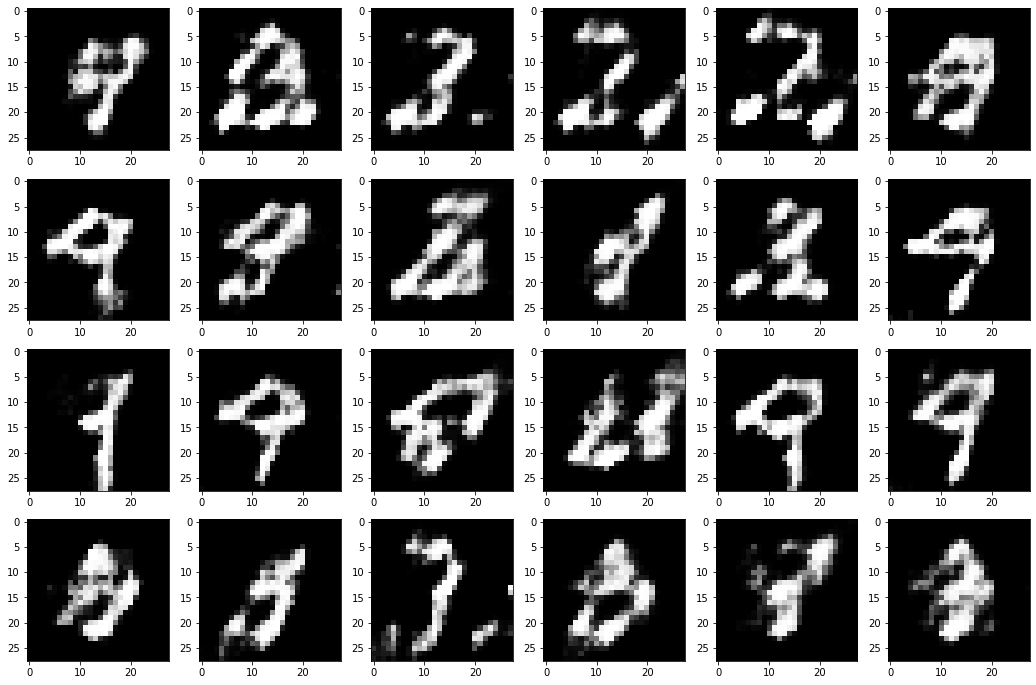

Epoch: 002: Gen Loss: 2.706, Disc Loss:0.797, IS: 2.939
examples of generated images after 2 epochs


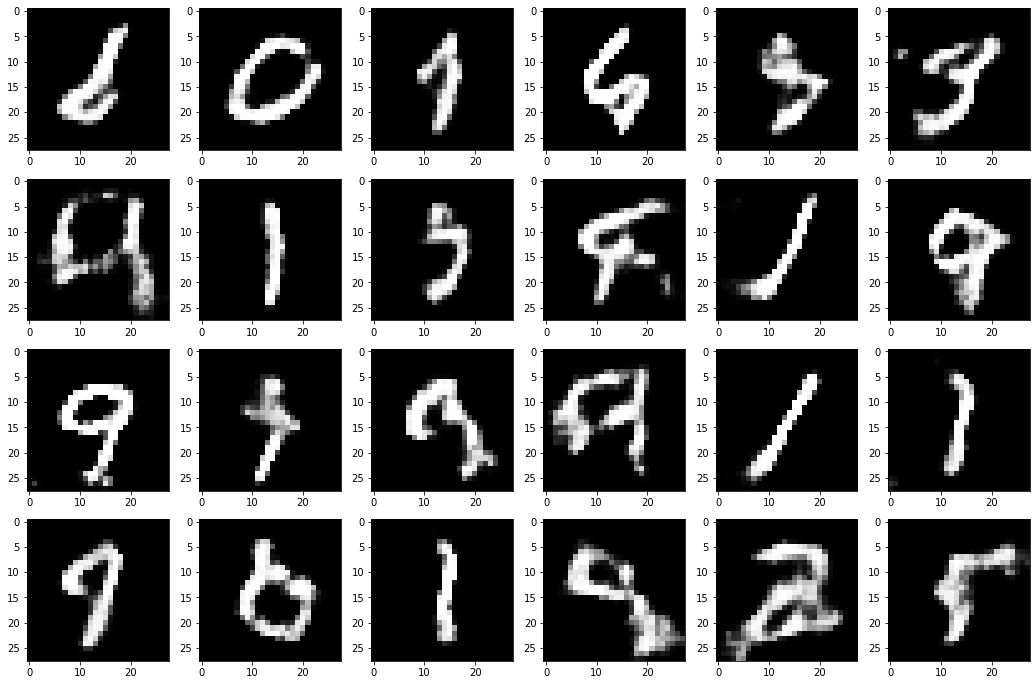

Epoch: 003: Gen Loss: 2.510, Disc Loss:0.835, IS: 2.894
examples of generated images after 3 epochs


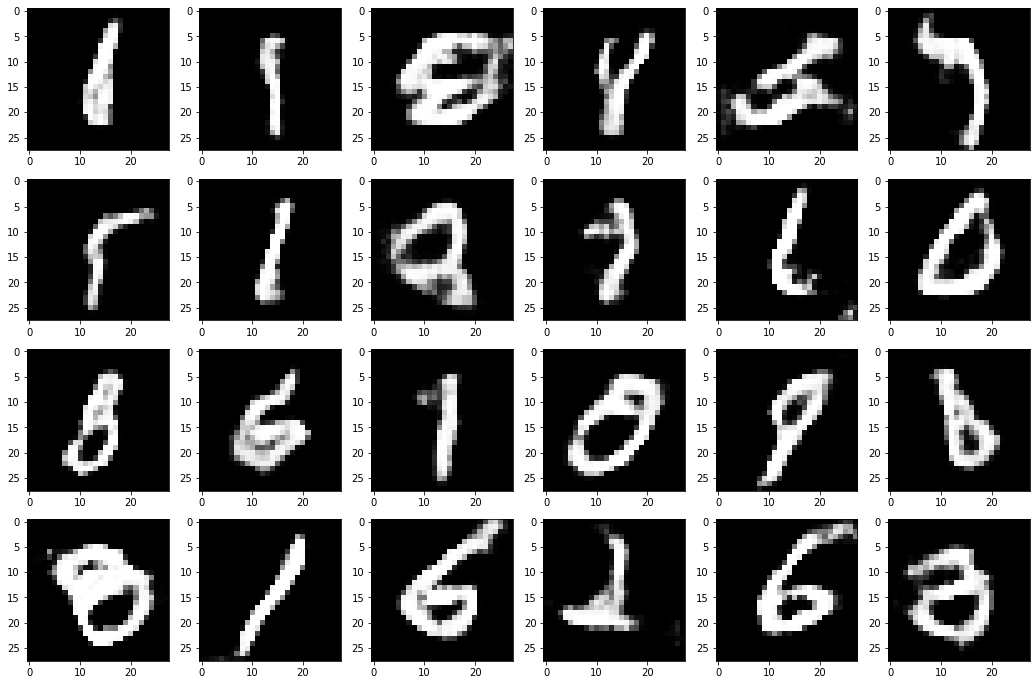

Epoch: 004: Gen Loss: 2.424, Disc Loss:0.857, IS: 3.040
examples of generated images after 4 epochs


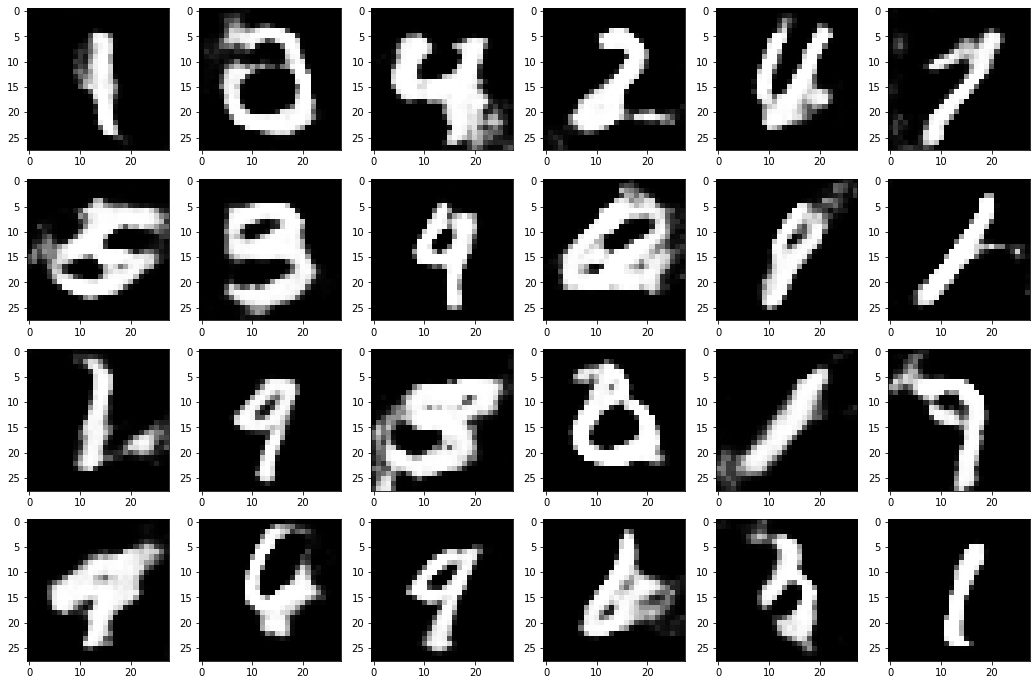

Epoch: 005: Gen Loss: 2.348, Disc Loss:0.871, IS: 2.821
examples of generated images after 5 epochs


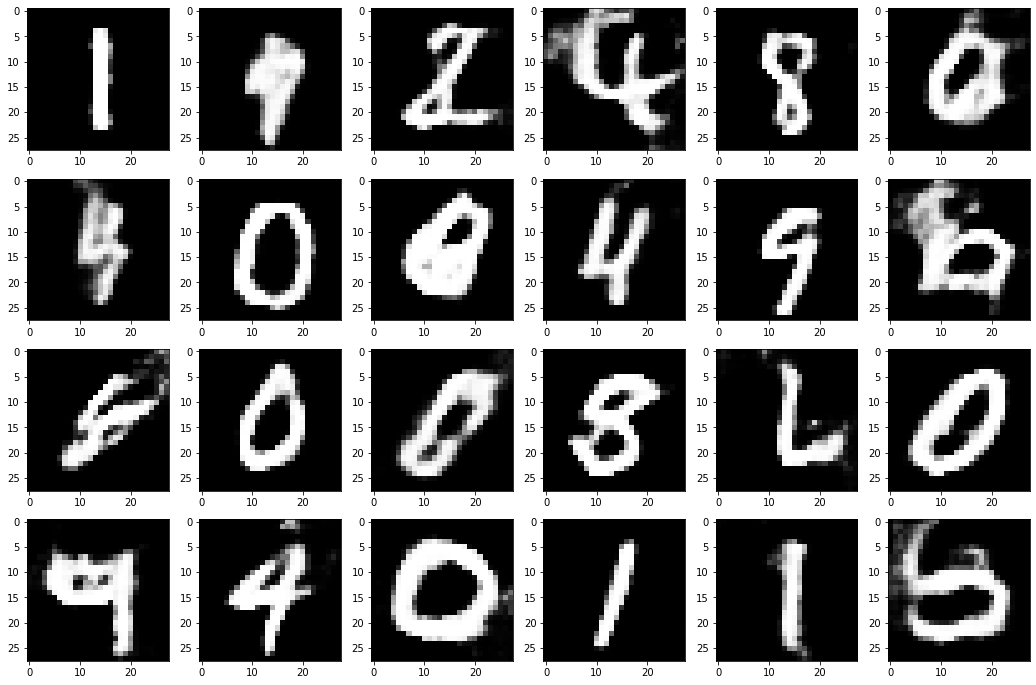

Epoch: 006: Gen Loss: 2.262, Disc Loss:0.884, IS: 2.706
examples of generated images after 6 epochs


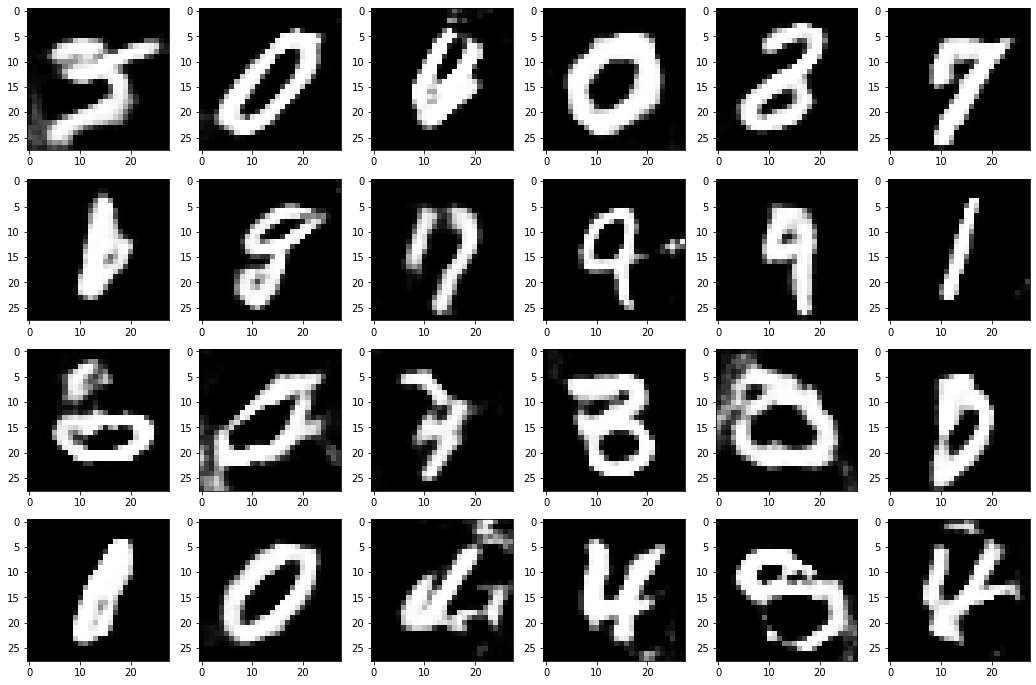

Epoch: 007: Gen Loss: 2.193, Disc Loss:0.891, IS: 2.678
examples of generated images after 7 epochs


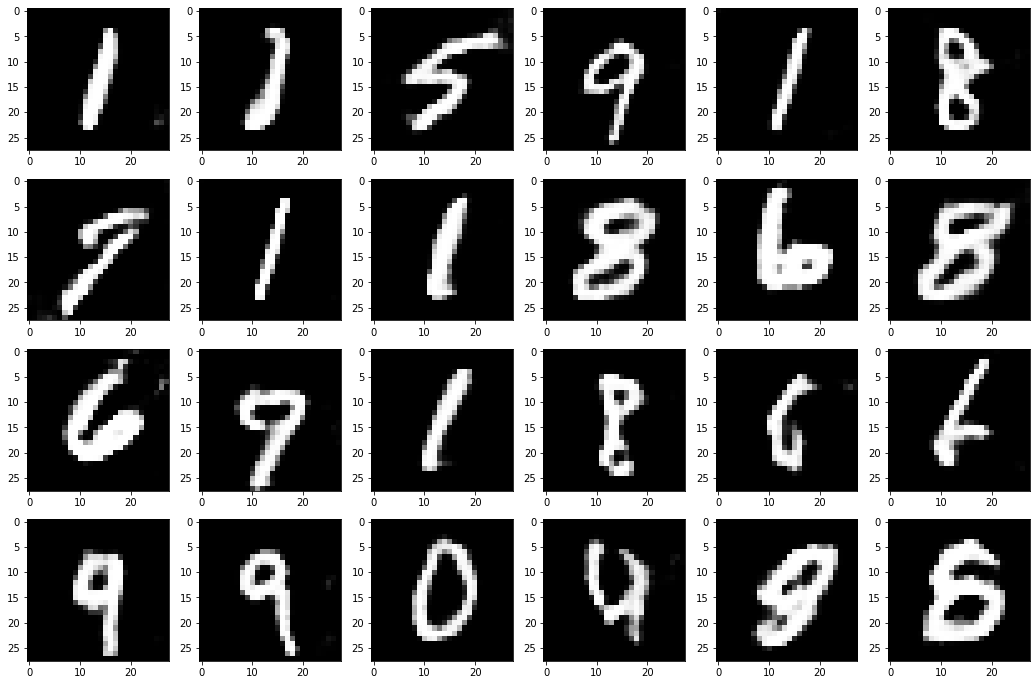

Epoch: 008: Gen Loss: 2.135, Disc Loss:0.900, IS: 2.613
examples of generated images after 8 epochs


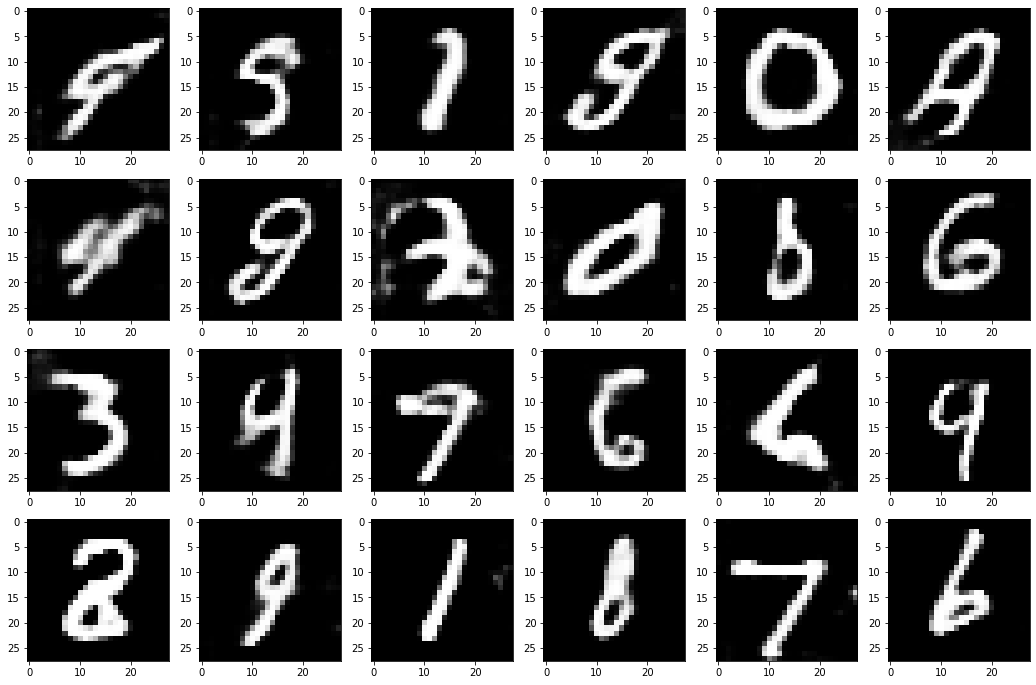

Epoch: 009: Gen Loss: 2.092, Disc Loss:0.906, IS: 2.571
examples of generated images after 9 epochs


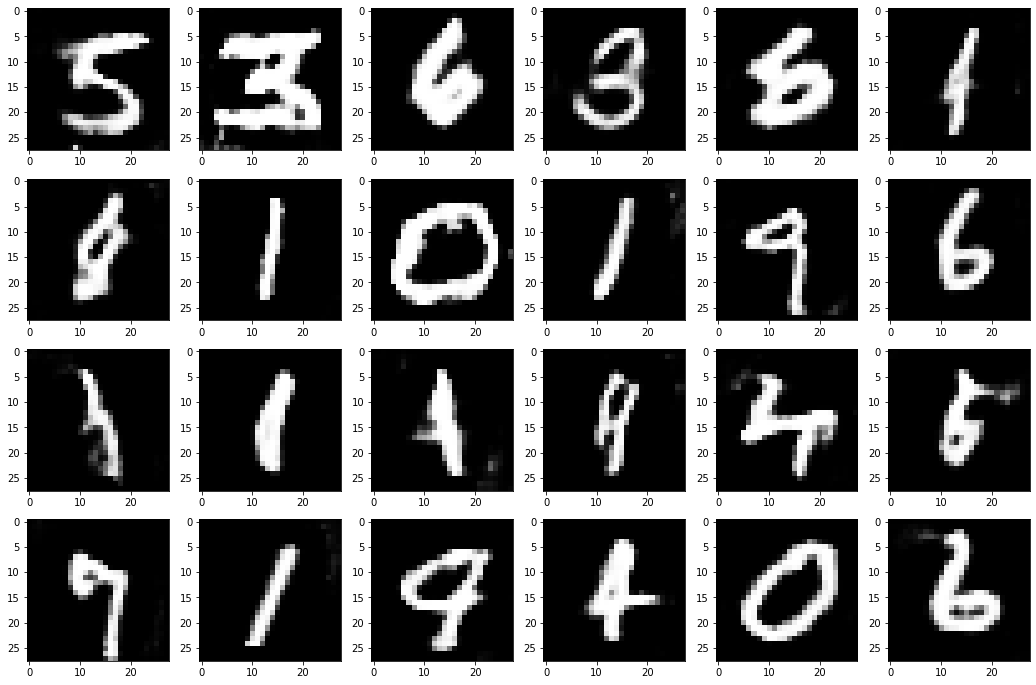

Epoch: 010: Gen Loss: 2.056, Disc Loss:0.905, IS: 2.601
examples of generated images after 10 epochs


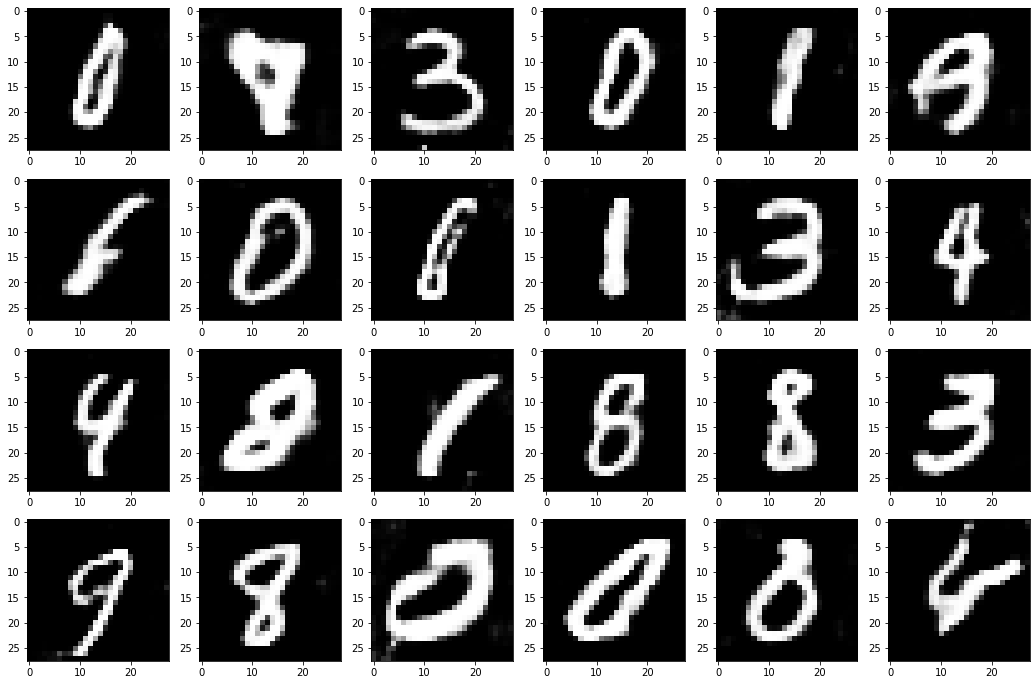

Epoch: 011: Gen Loss: 2.034, Disc Loss:0.905, IS: 2.466
examples of generated images after 11 epochs


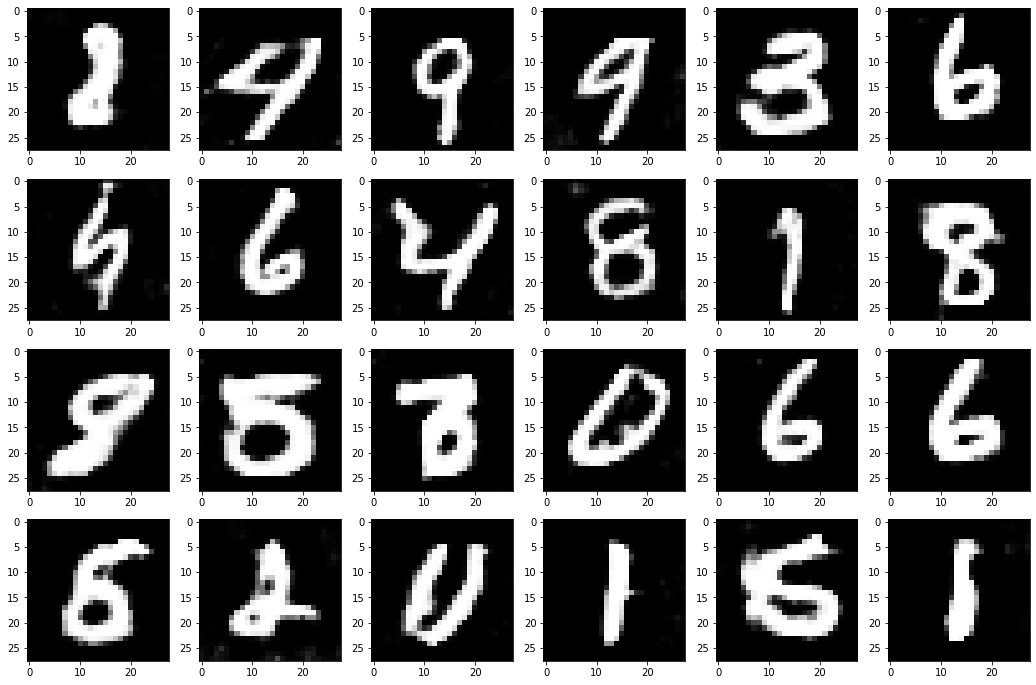

Epoch: 012: Gen Loss: 2.007, Disc Loss:0.903, IS: 2.380
examples of generated images after 12 epochs


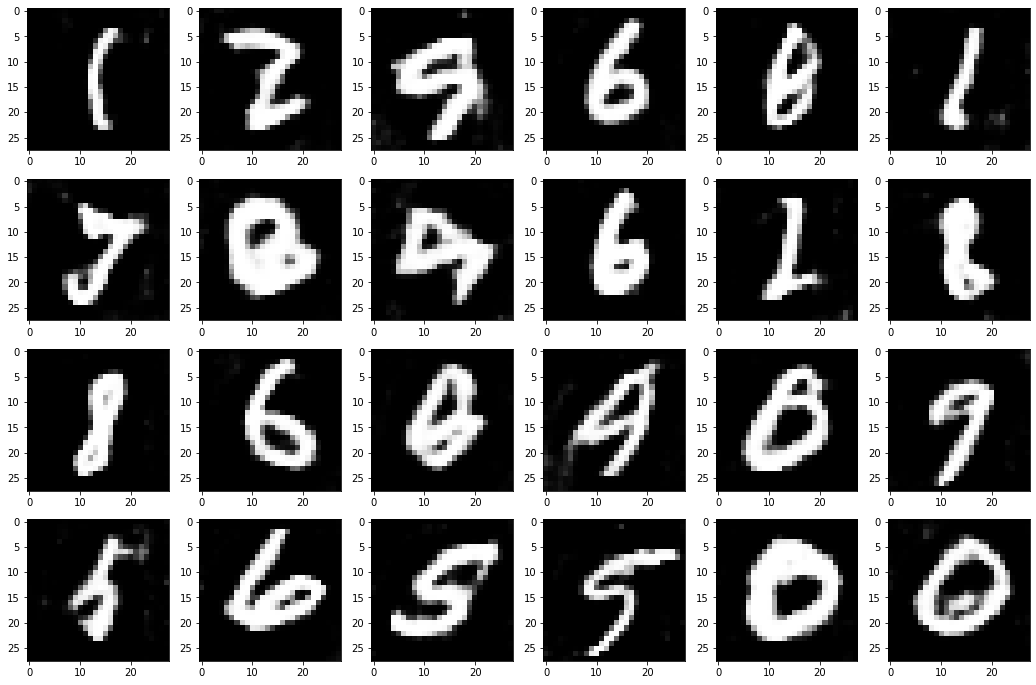

Epoch: 013: Gen Loss: 1.982, Disc Loss:0.899, IS: 2.416
examples of generated images after 13 epochs


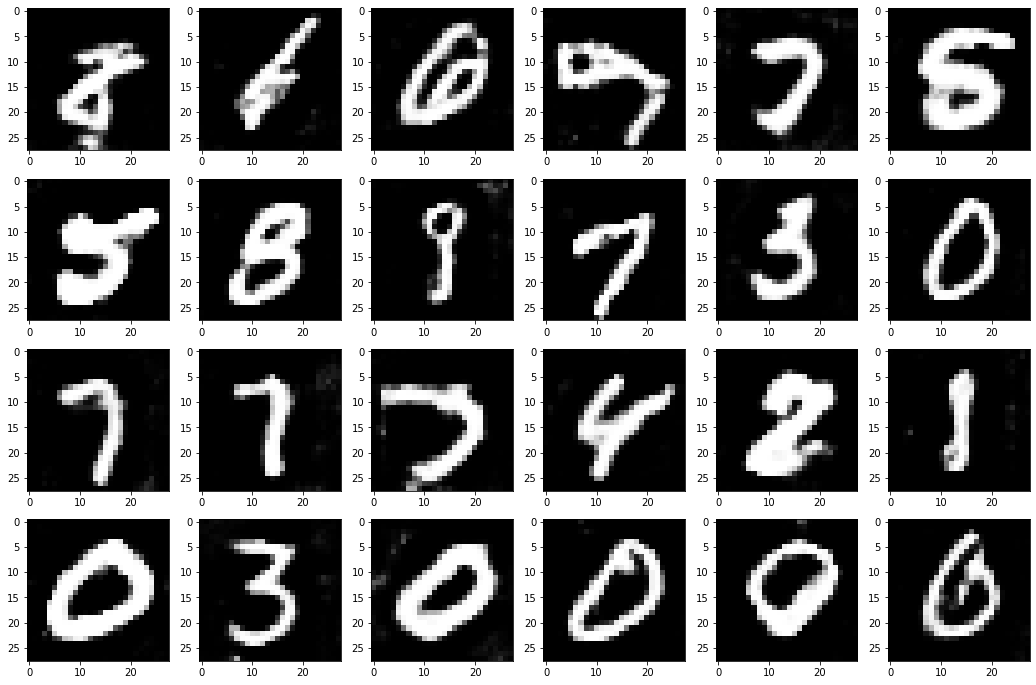

Epoch: 014: Gen Loss: 1.968, Disc Loss:0.897, IS: 2.441
examples of generated images after 14 epochs


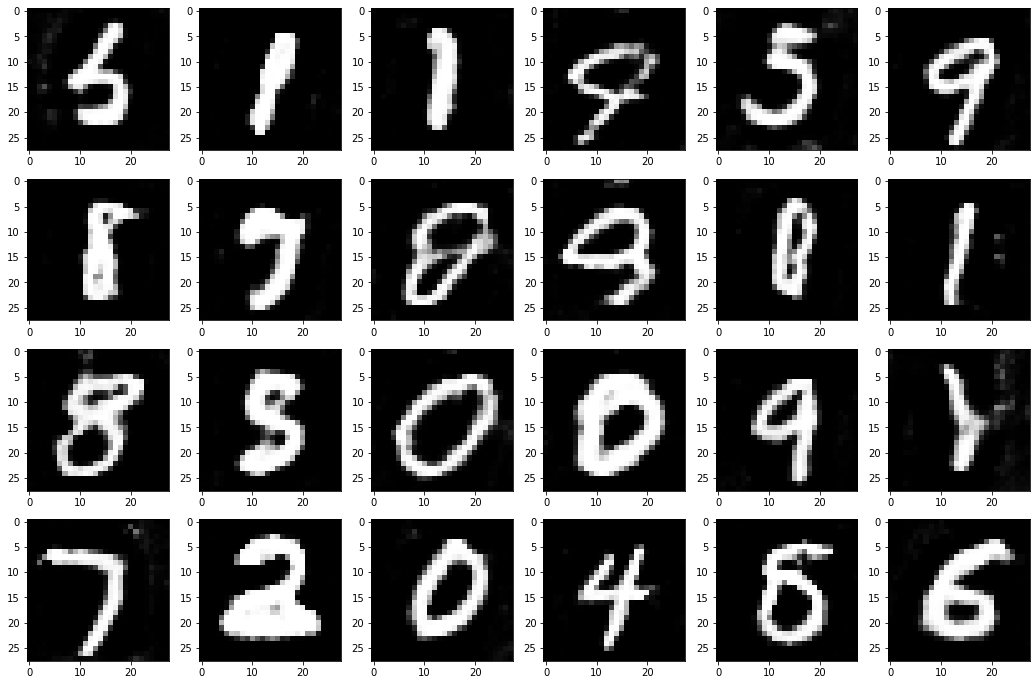

Epoch: 015: Gen Loss: 1.957, Disc Loss:0.894, IS: 2.420
examples of generated images after 15 epochs


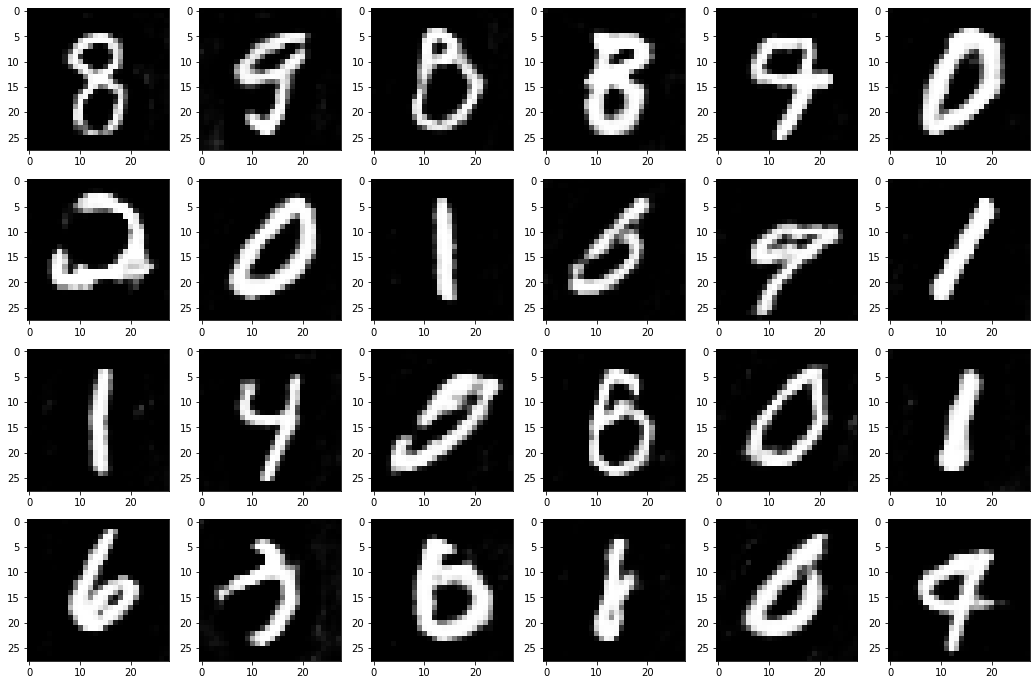

time: 982.904153 sec


In [ ]:
dcgan = DCGAN(tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), x_train, y_train, batch_size=64, use_averaging=False,
                path='/content/drive/My Drive/Univ/Final models/Saved models/DCGAN Adam/')
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

Epoch: 016: Gen Loss: 1.945, Disc Loss:0.890, IS: 2.413, IS_avr: 2.522
examples of generated images after 16 epochs


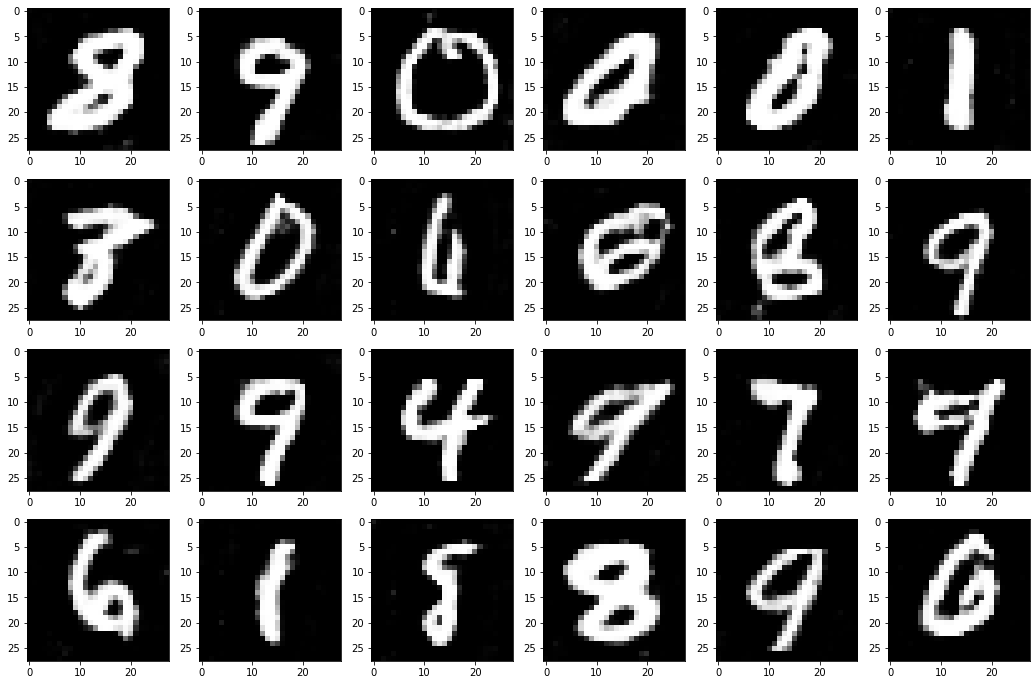

examples of generated images using average variables after 16 epochs


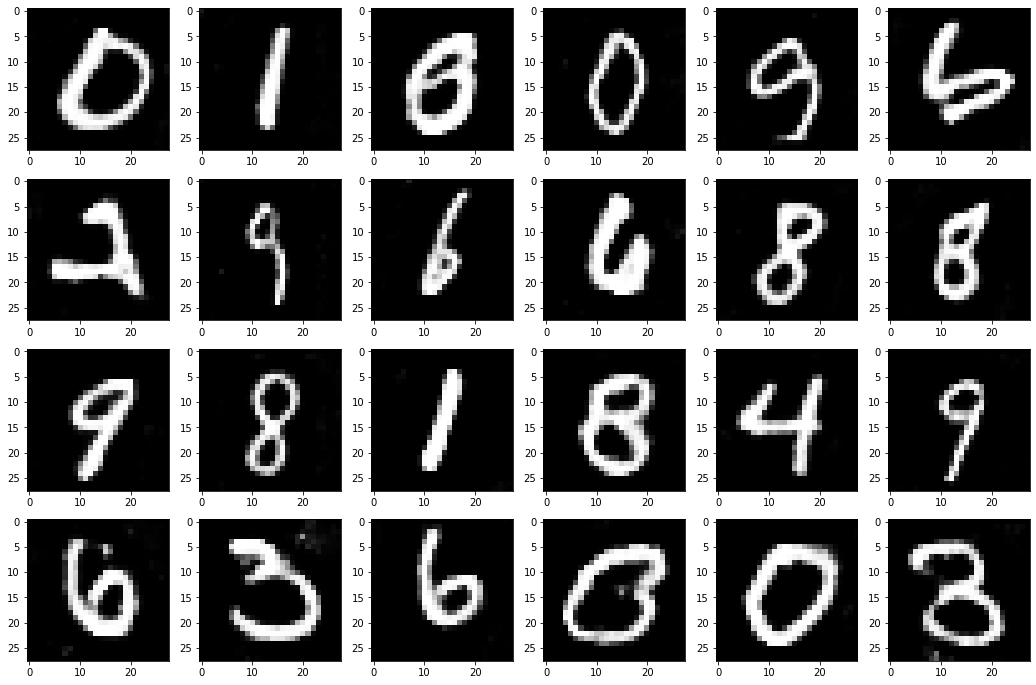

Epoch: 017: Gen Loss: 1.936, Disc Loss:0.886, IS: 2.538, IS_avr: 2.516
examples of generated images after 17 epochs


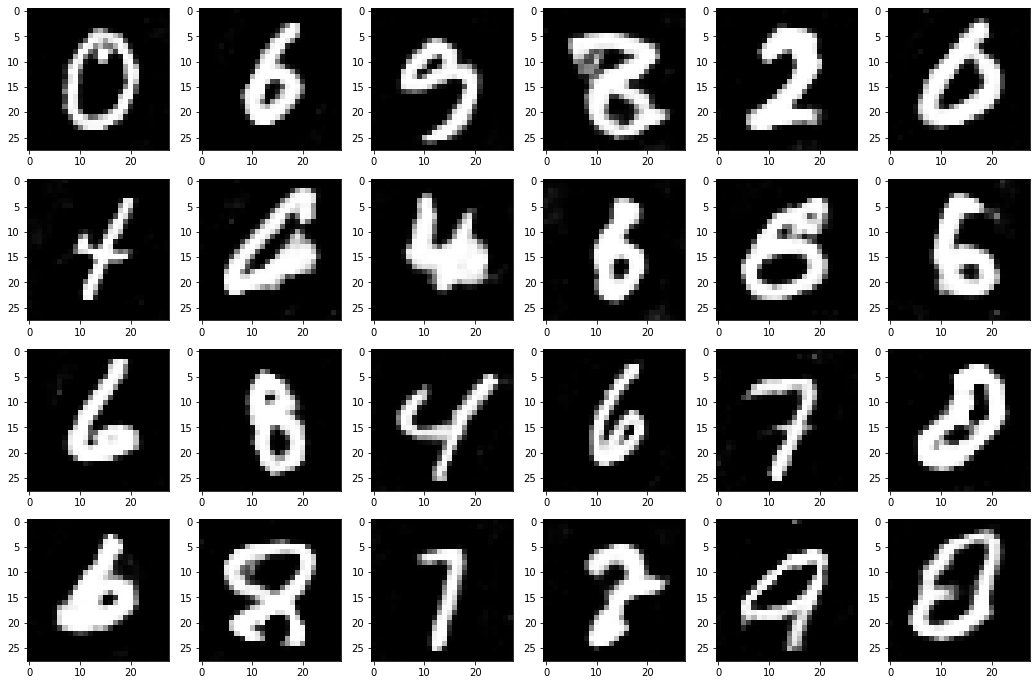

examples of generated images using average variables after 17 epochs


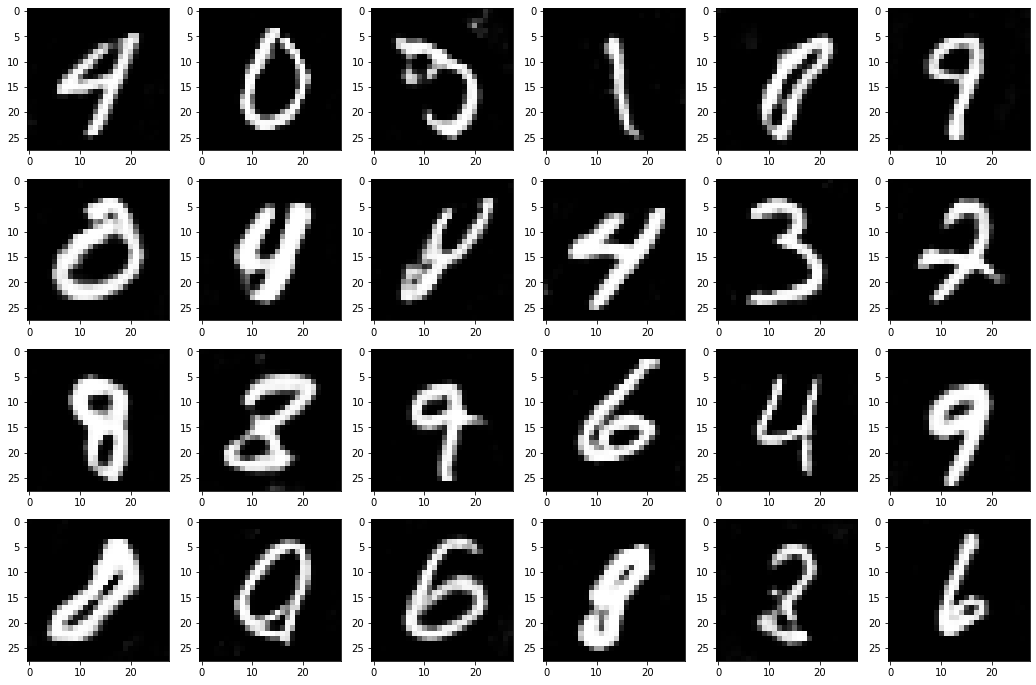

Epoch: 018: Gen Loss: 1.935, Disc Loss:0.882, IS: 2.408, IS_avr: 2.485
examples of generated images after 18 epochs


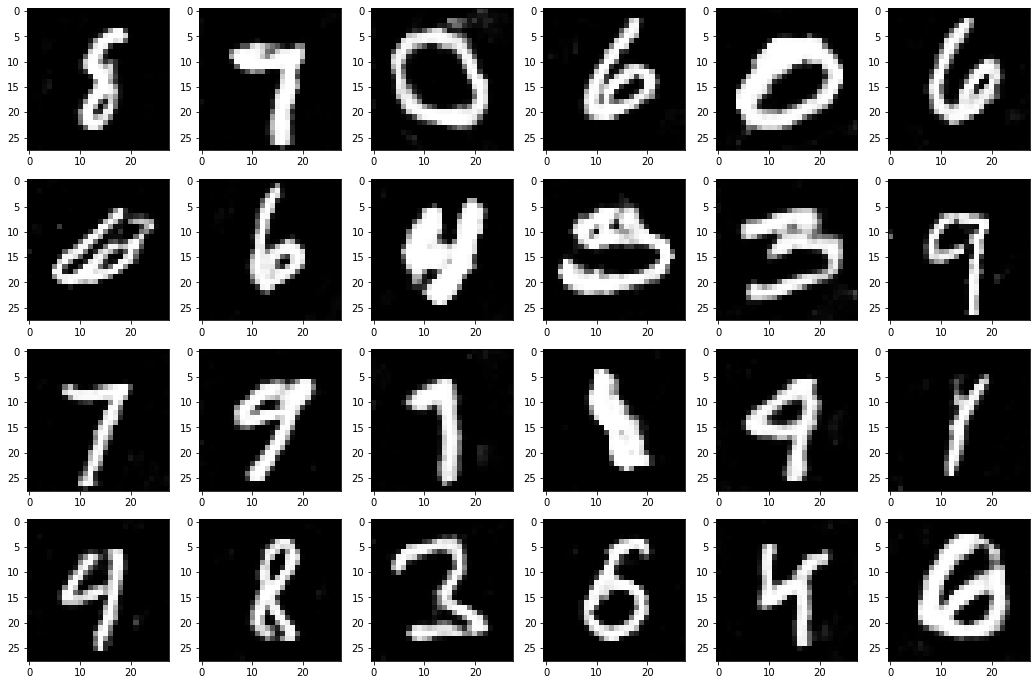

examples of generated images using average variables after 18 epochs


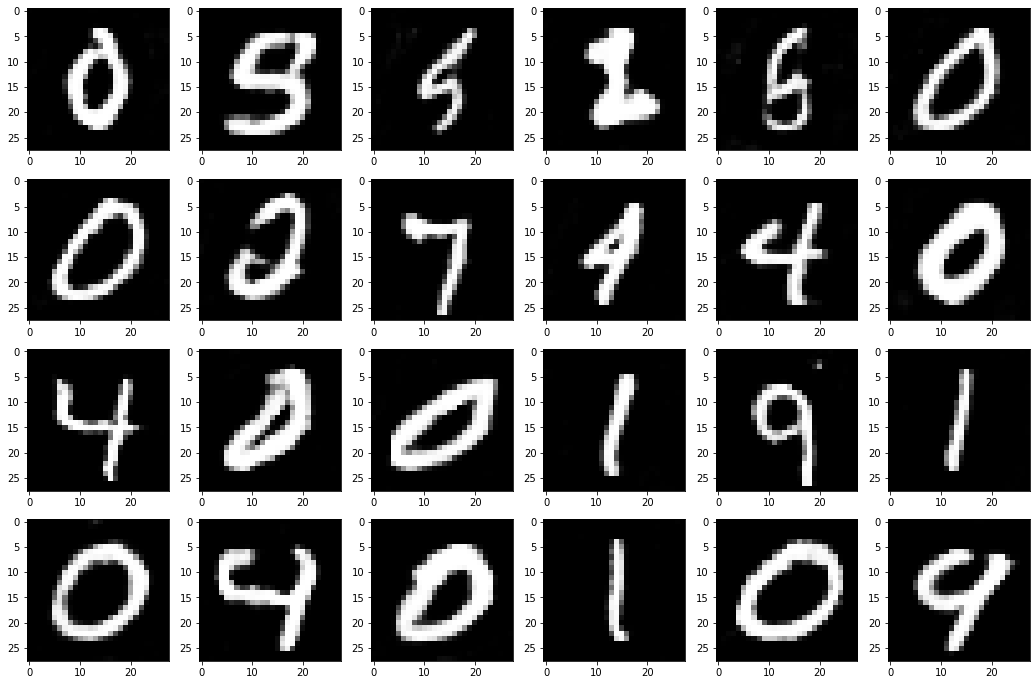

Epoch: 019: Gen Loss: 1.926, Disc Loss:0.878, IS: 2.386, IS_avr: 2.458
examples of generated images after 19 epochs


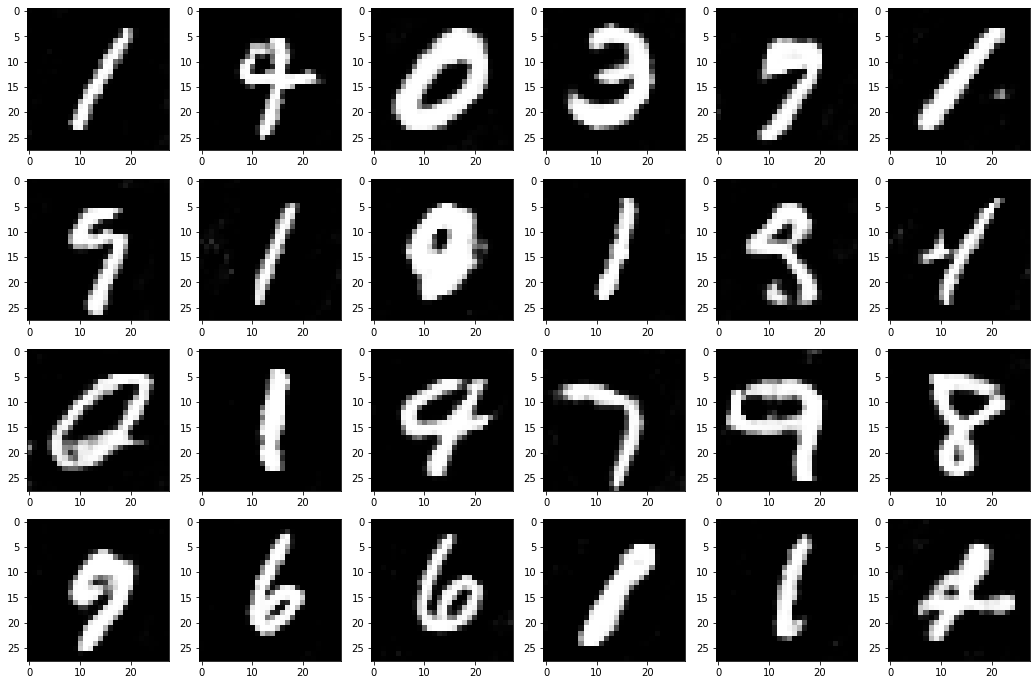

examples of generated images using average variables after 19 epochs


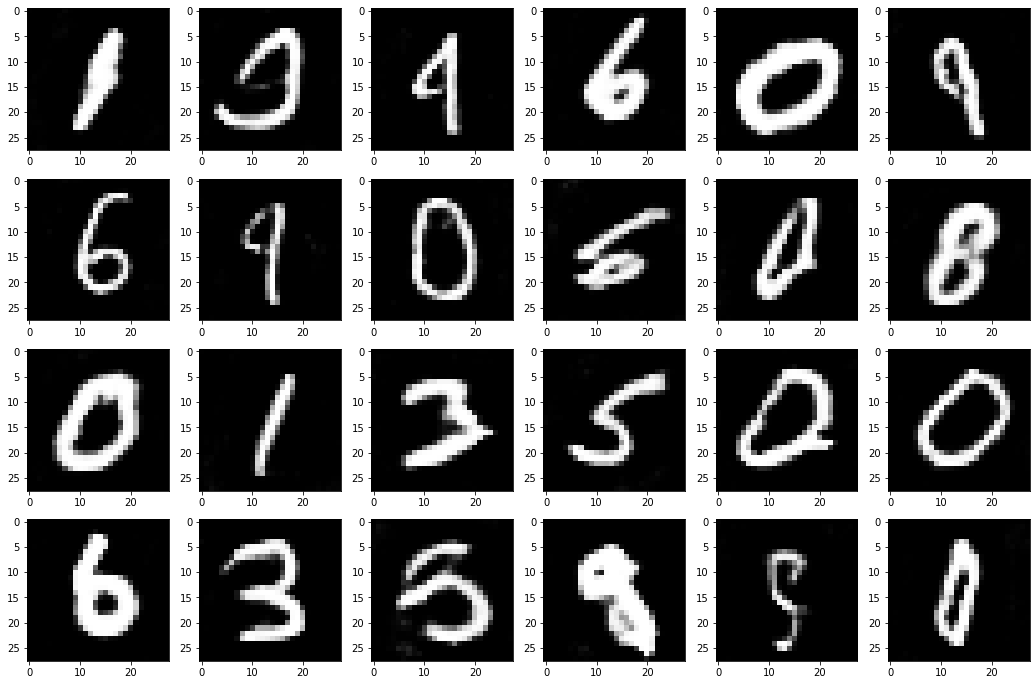

Epoch: 020: Gen Loss: 1.929, Disc Loss:0.876, IS: 2.358, IS_avr: 2.451
examples of generated images after 20 epochs


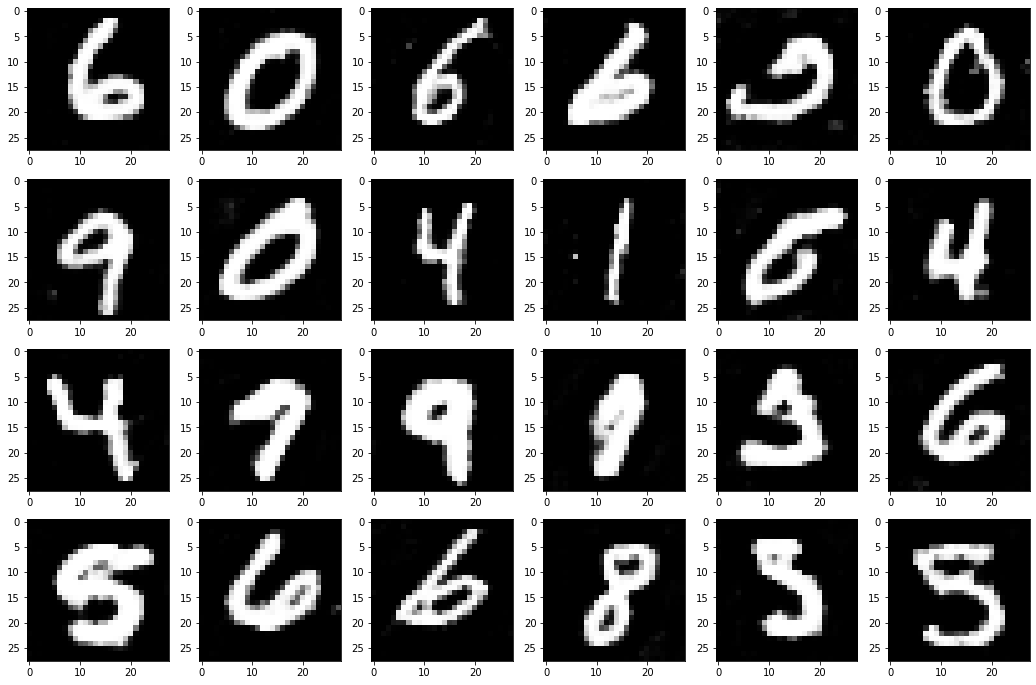

examples of generated images using average variables after 20 epochs


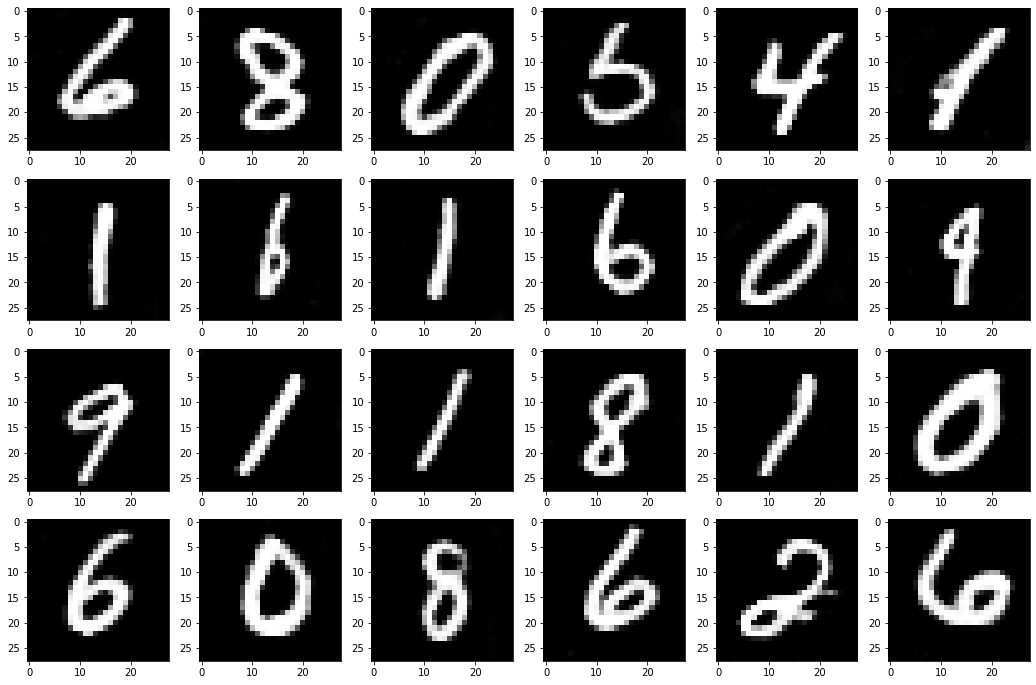

Epoch: 021: Gen Loss: 1.930, Disc Loss:0.875, IS: 2.434, IS_avr: 2.470
examples of generated images after 21 epochs


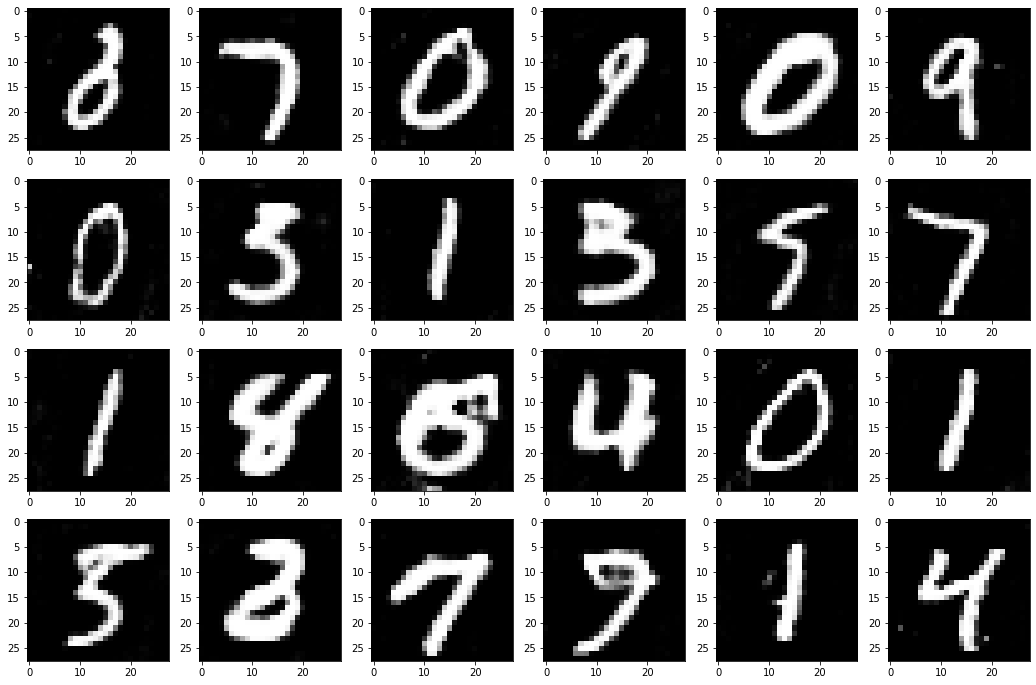

examples of generated images using average variables after 21 epochs


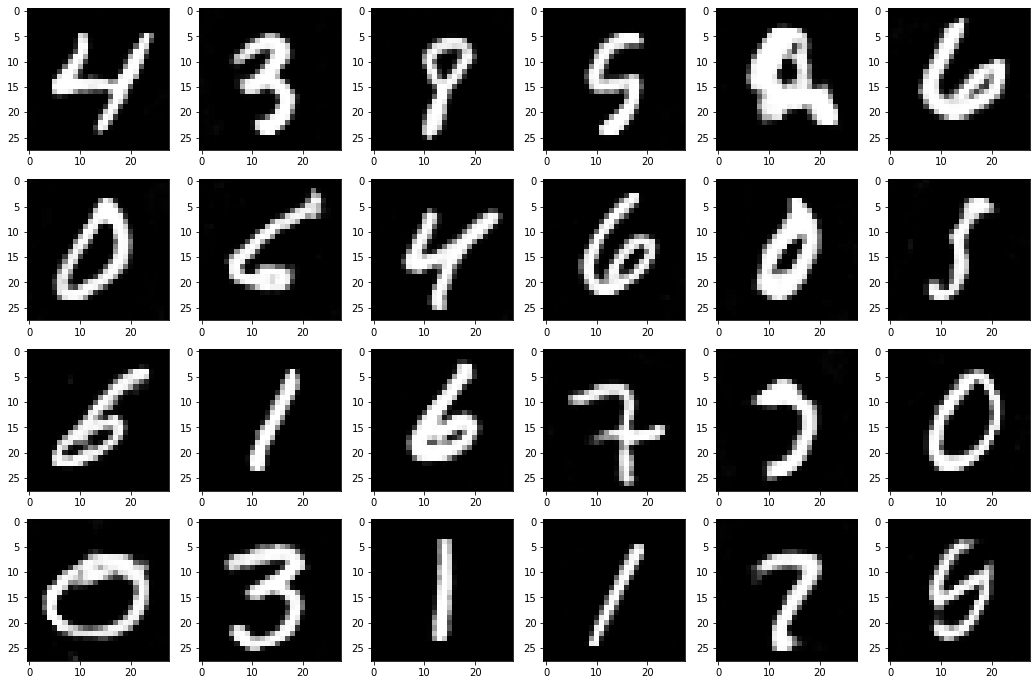

Epoch: 022: Gen Loss: 1.927, Disc Loss:0.871, IS: 2.423, IS_avr: 2.420
examples of generated images after 22 epochs


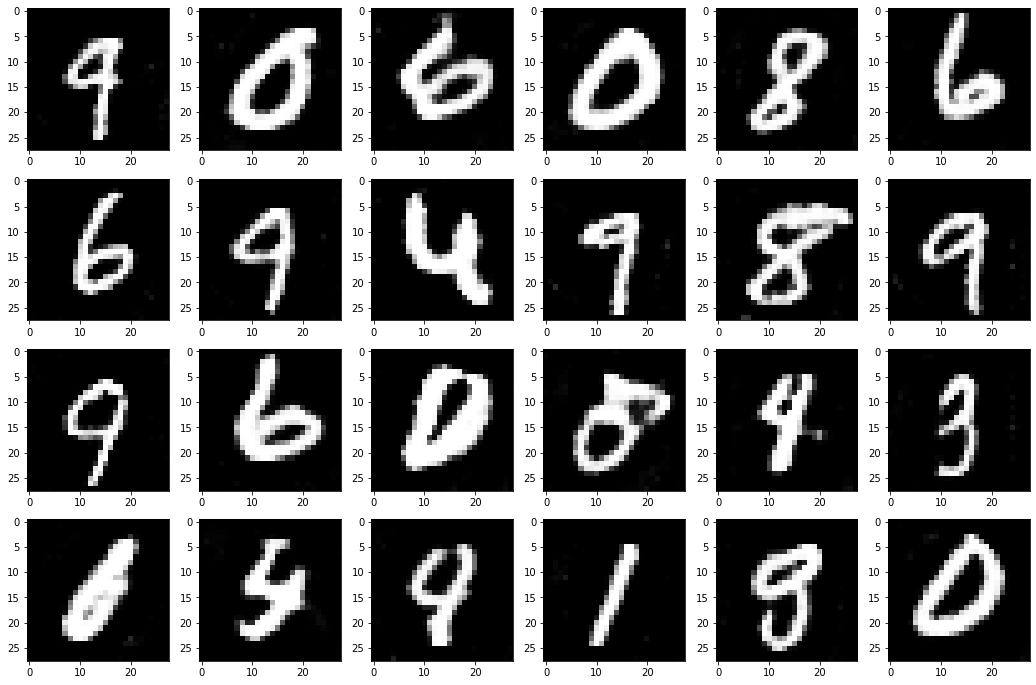

examples of generated images using average variables after 22 epochs


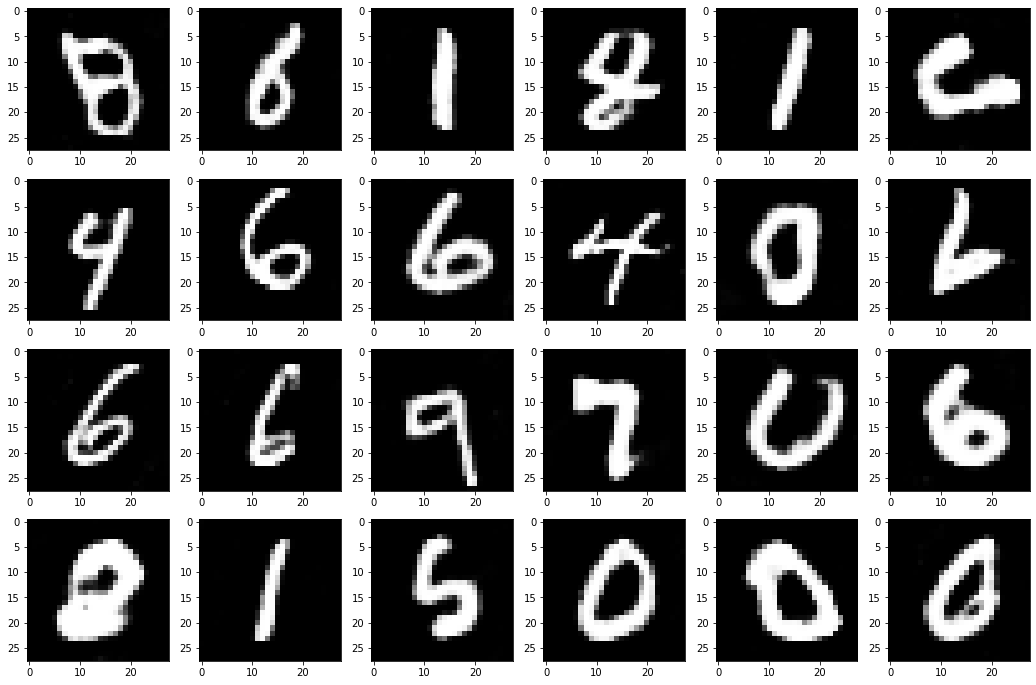

Epoch: 023: Gen Loss: 1.919, Disc Loss:0.866, IS: 2.458, IS_avr: 2.548
examples of generated images after 23 epochs


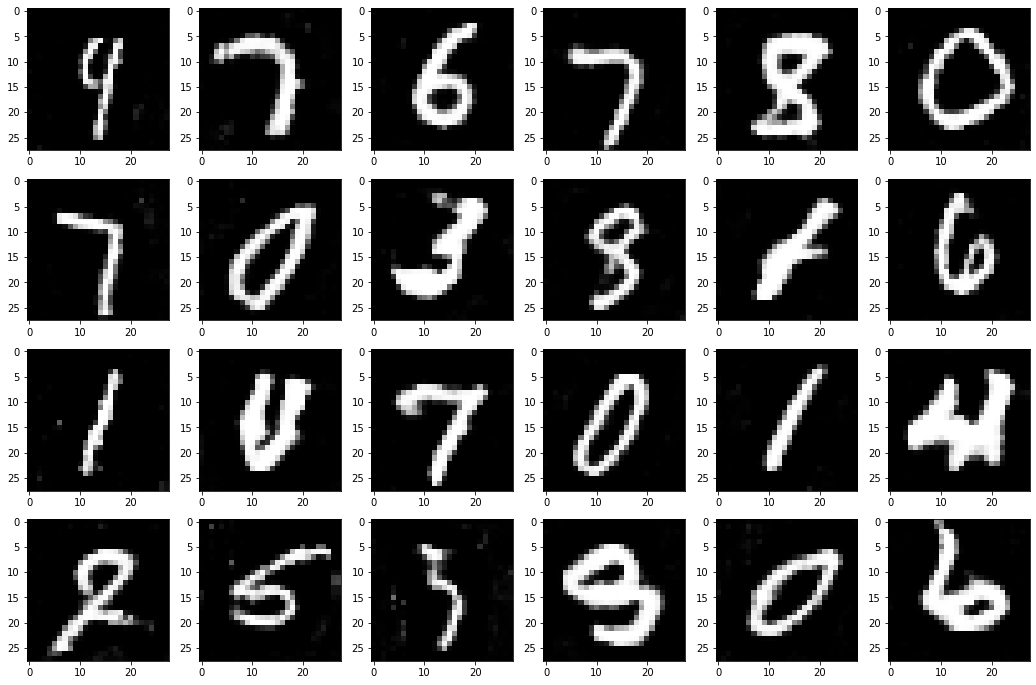

examples of generated images using average variables after 23 epochs


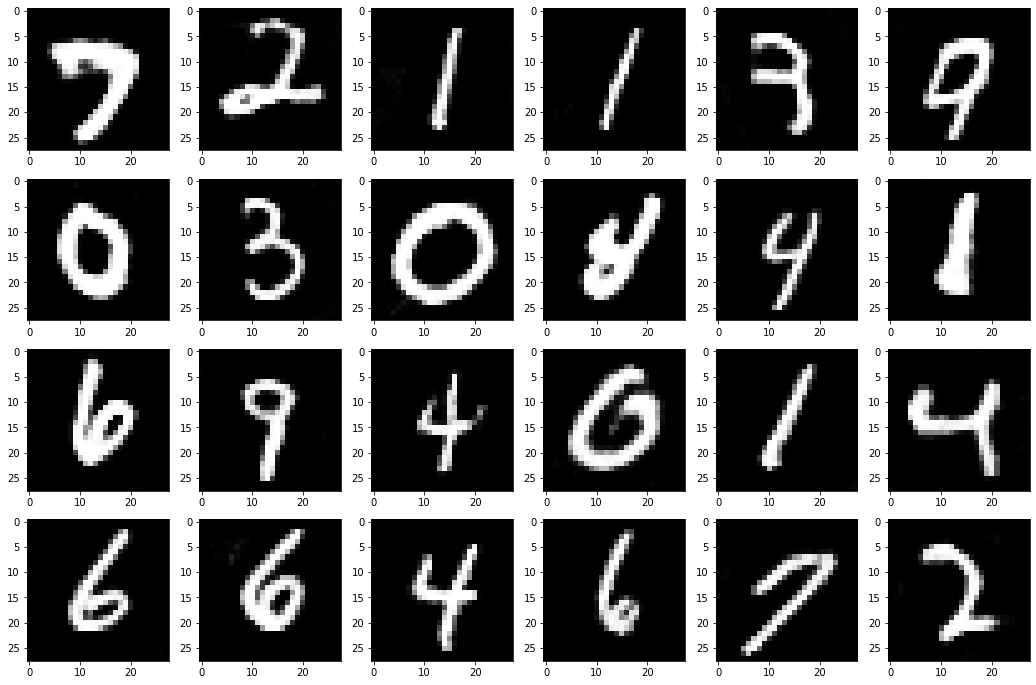

Epoch: 024: Gen Loss: 1.923, Disc Loss:0.863, IS: 2.436, IS_avr: 2.488
examples of generated images after 24 epochs


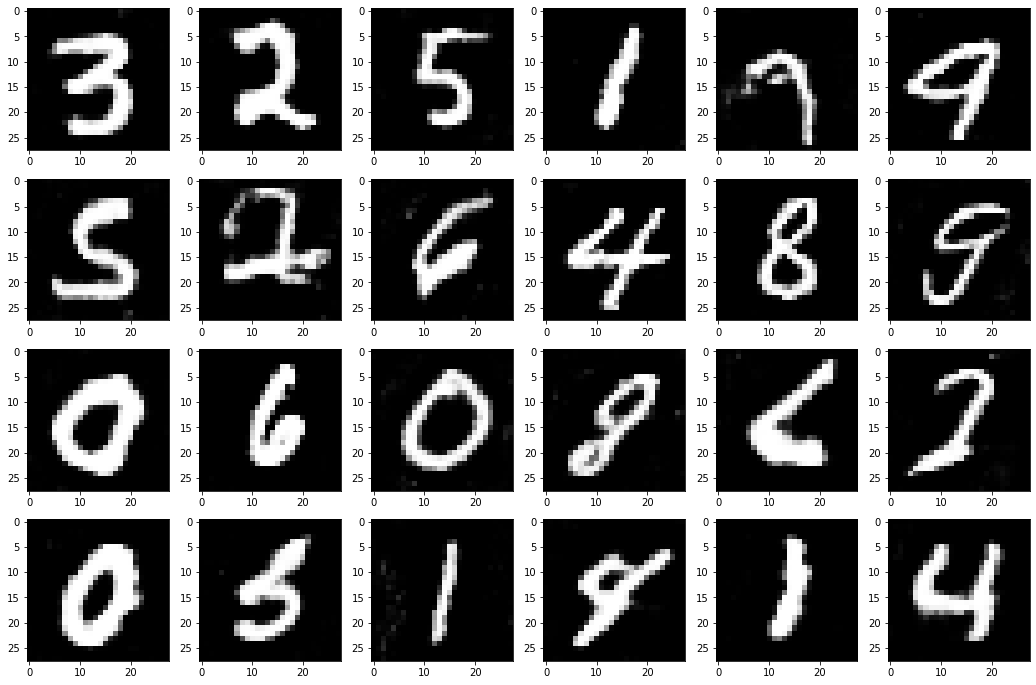

examples of generated images using average variables after 24 epochs


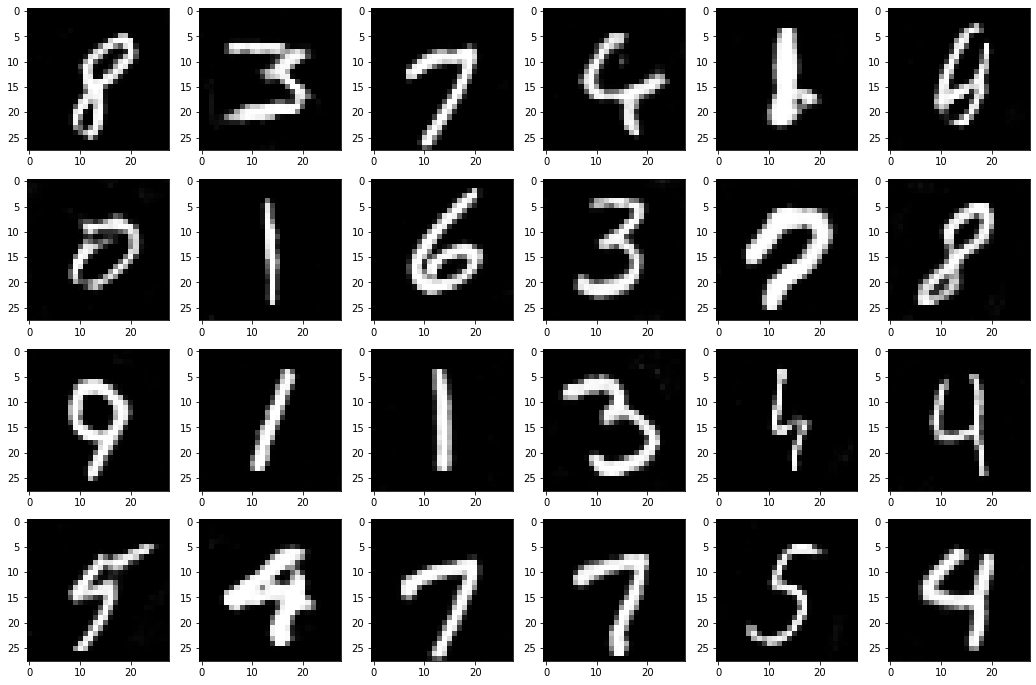

Epoch: 025: Gen Loss: 1.909, Disc Loss:0.859, IS: 2.462, IS_avr: 2.525
examples of generated images after 25 epochs


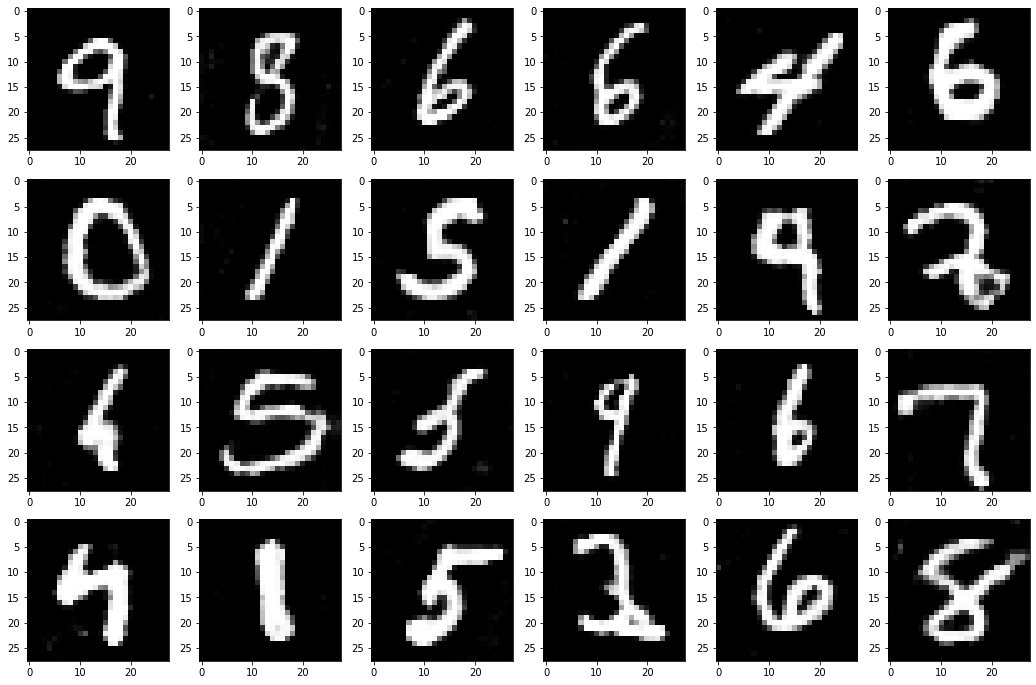

examples of generated images using average variables after 25 epochs


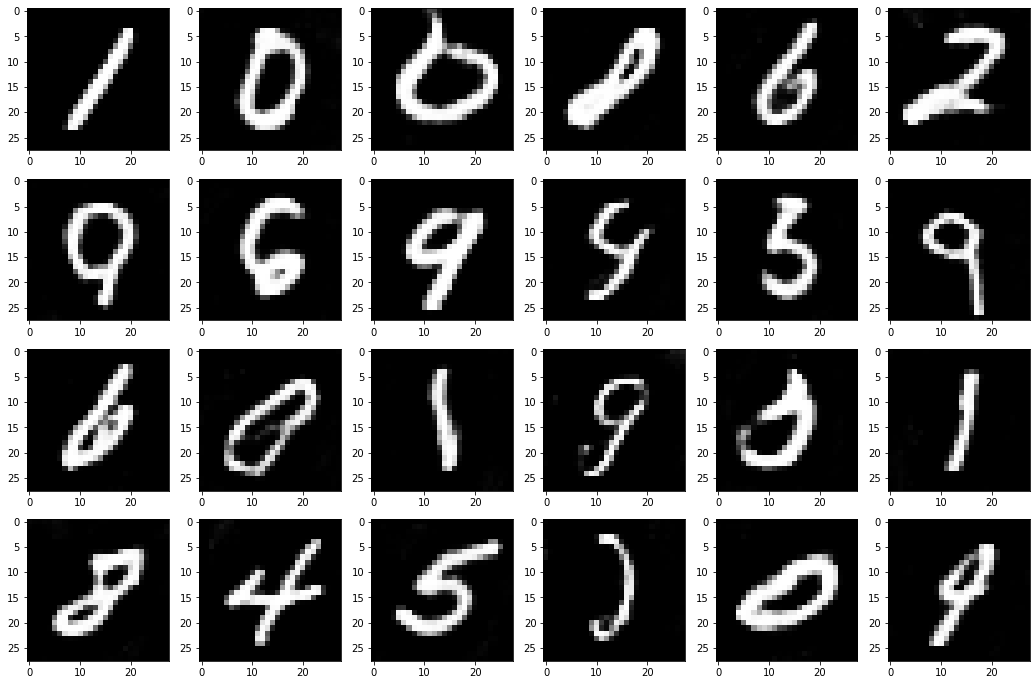

Epoch: 026: Gen Loss: 1.921, Disc Loss:0.858, IS: 2.382, IS_avr: 2.497
examples of generated images after 26 epochs


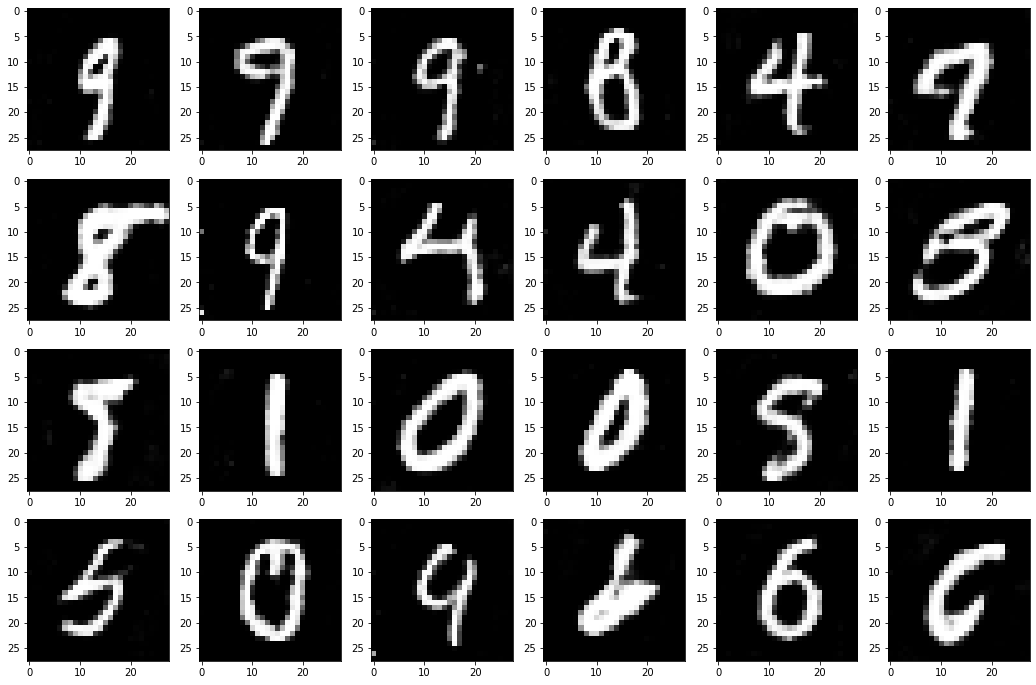

examples of generated images using average variables after 26 epochs


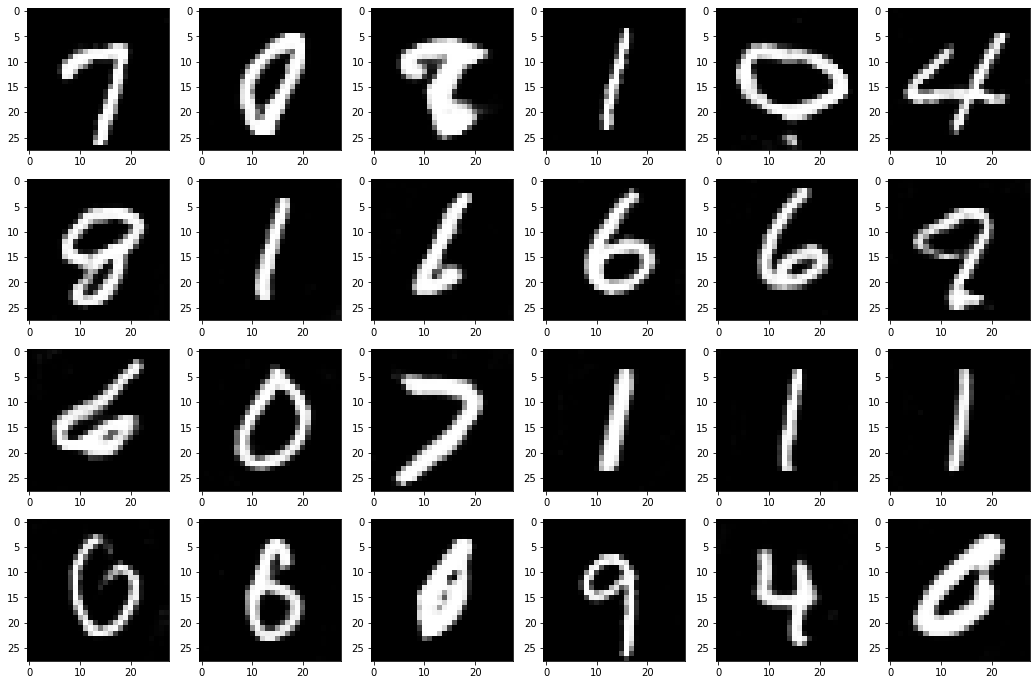

Epoch: 027: Gen Loss: 1.915, Disc Loss:0.854, IS: 2.507, IS_avr: 2.515
examples of generated images after 27 epochs


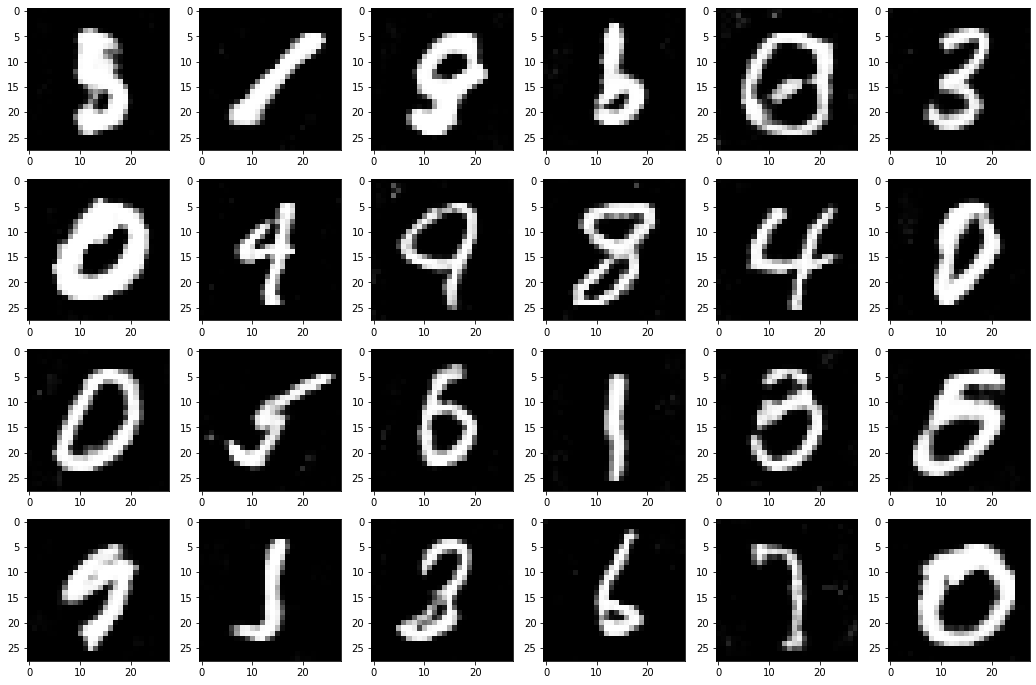

examples of generated images using average variables after 27 epochs


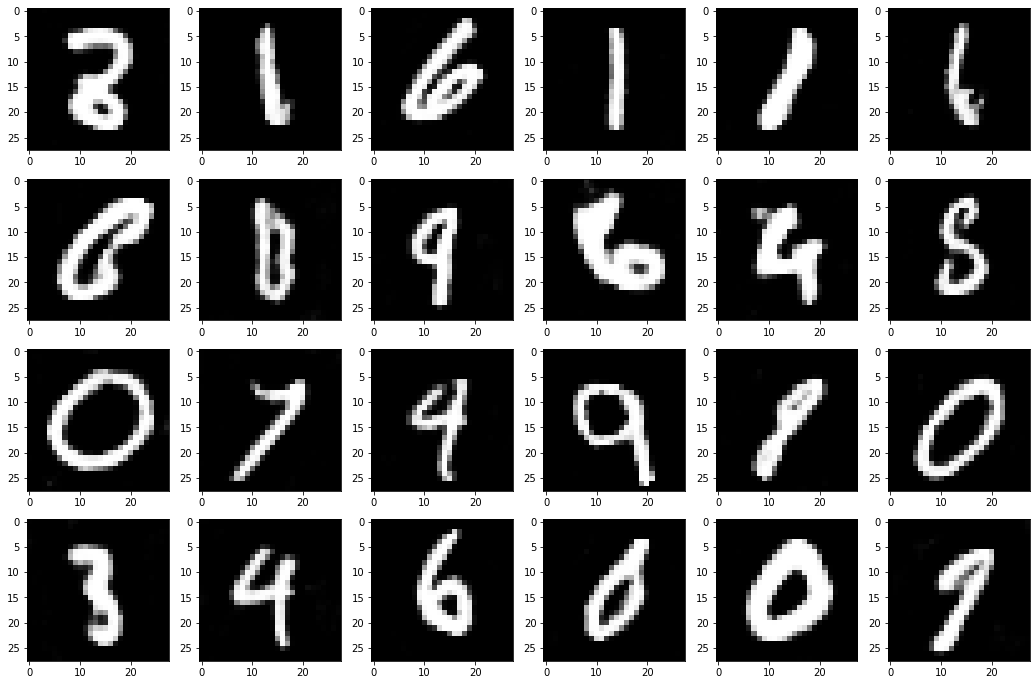

Epoch: 028: Gen Loss: 1.919, Disc Loss:0.853, IS: 2.473, IS_avr: 2.564
examples of generated images after 28 epochs


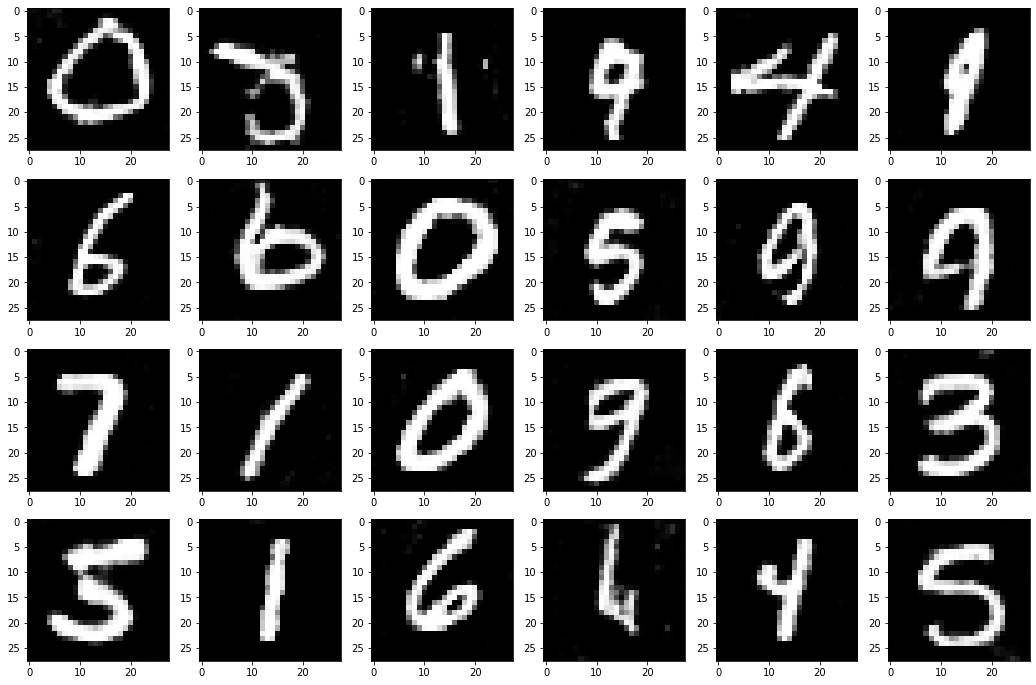

examples of generated images using average variables after 28 epochs


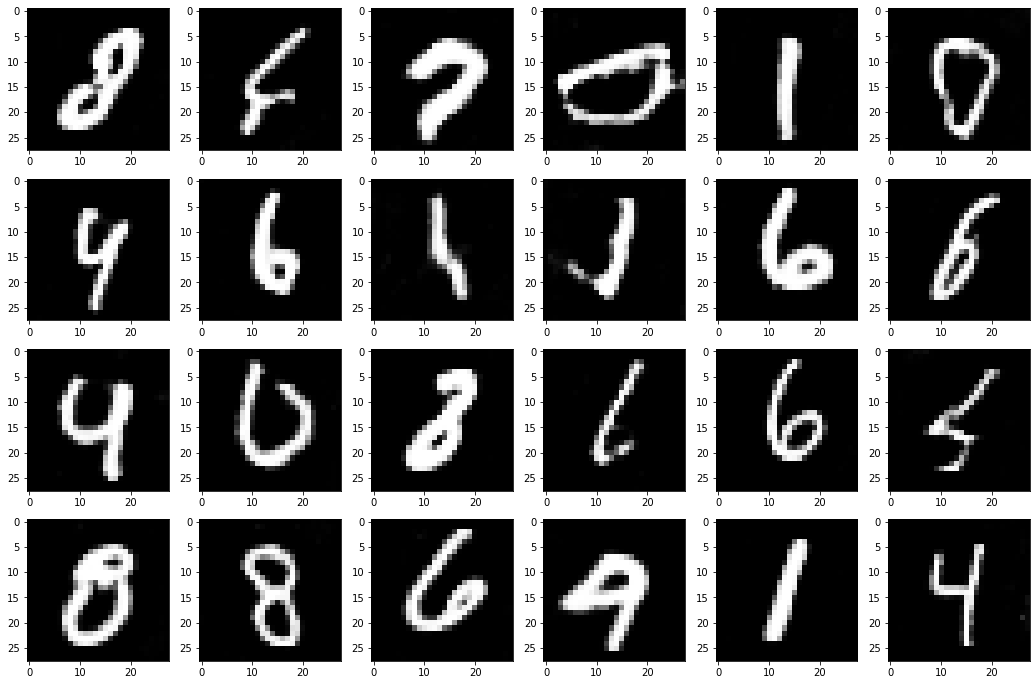

Epoch: 029: Gen Loss: 1.915, Disc Loss:0.850, IS: 2.443, IS_avr: 2.438
examples of generated images after 29 epochs


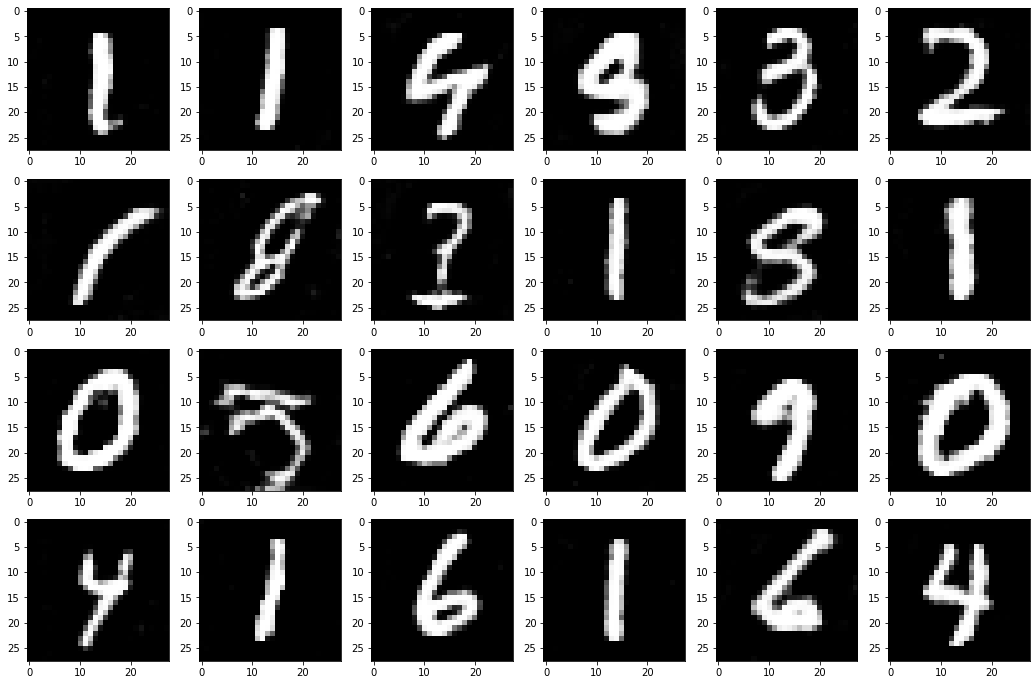

examples of generated images using average variables after 29 epochs


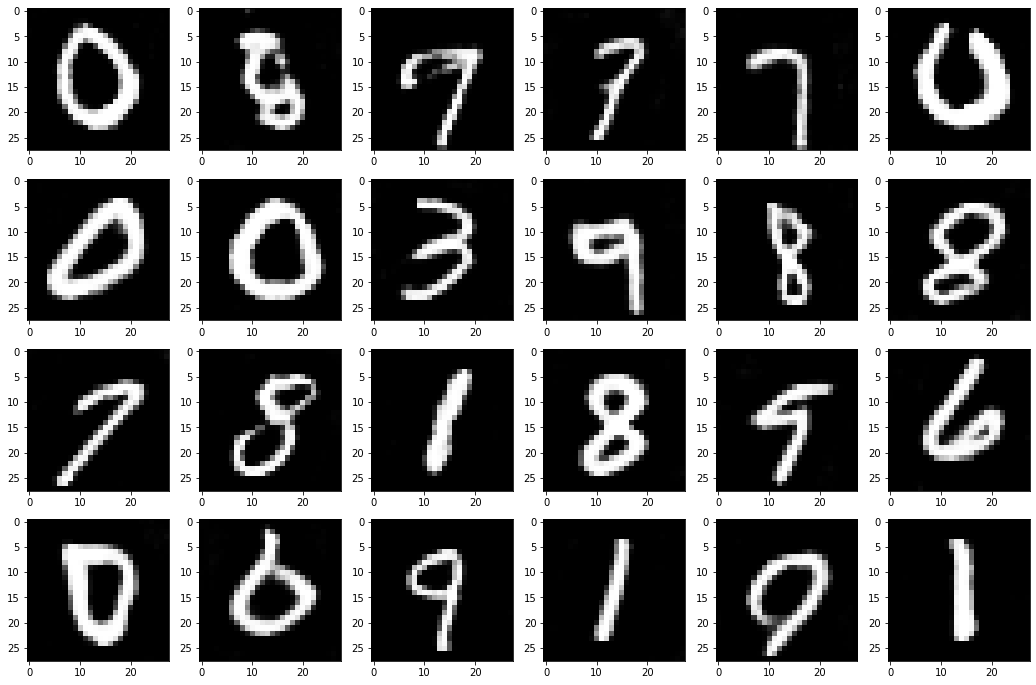

Epoch: 030: Gen Loss: 1.909, Disc Loss:0.847, IS: 2.515, IS_avr: 2.418
examples of generated images after 30 epochs


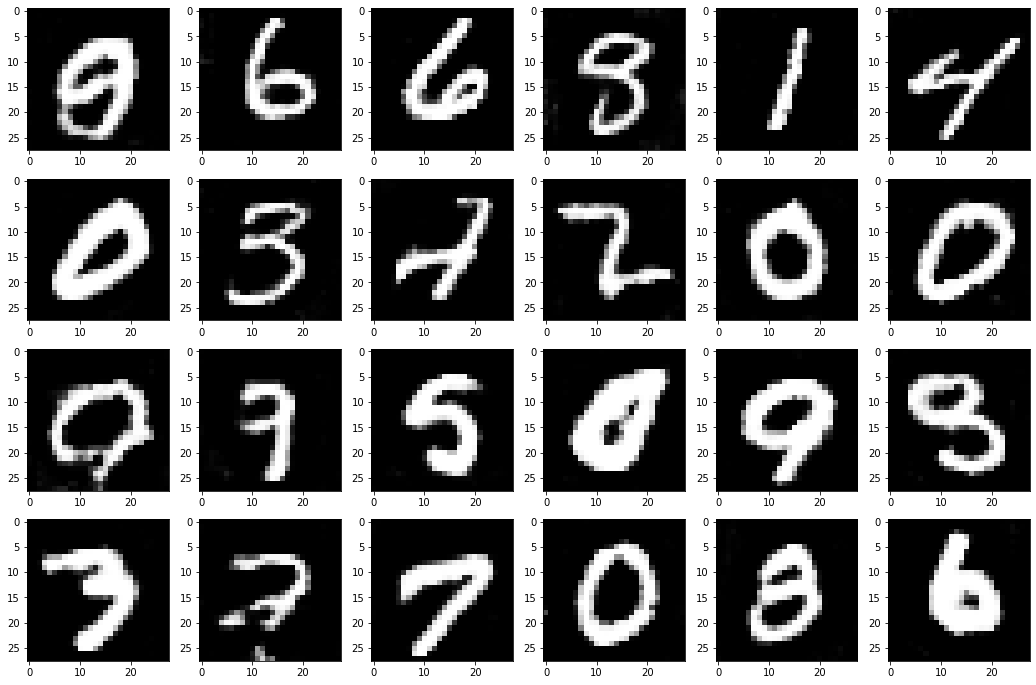

examples of generated images using average variables after 30 epochs


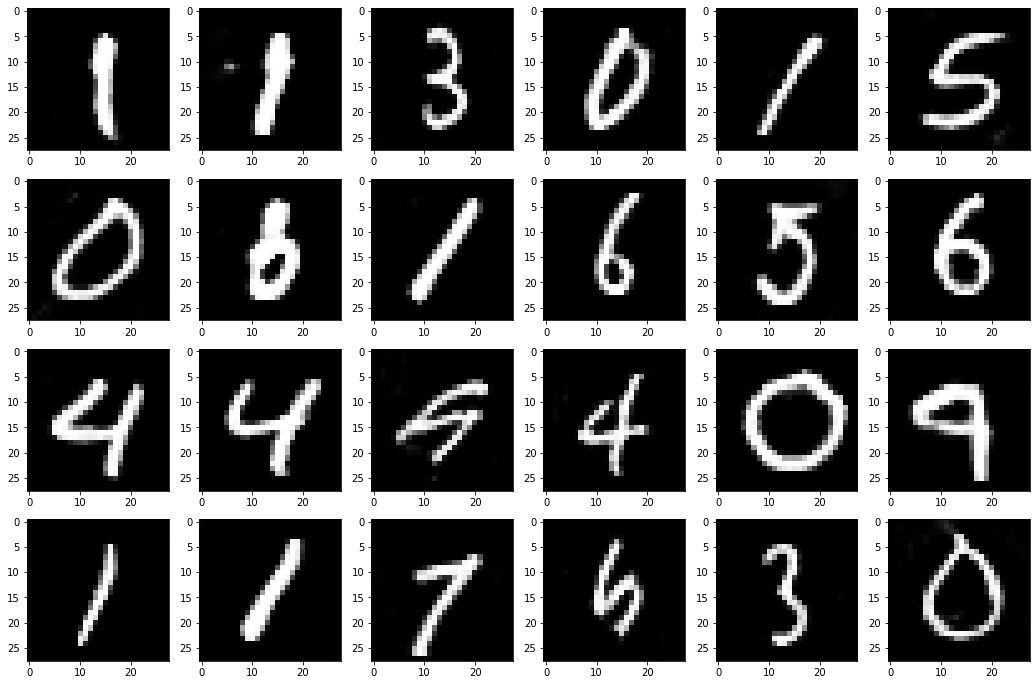

time: 1403.13143 sec


In [ ]:
dcgan.use_averaging = True
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

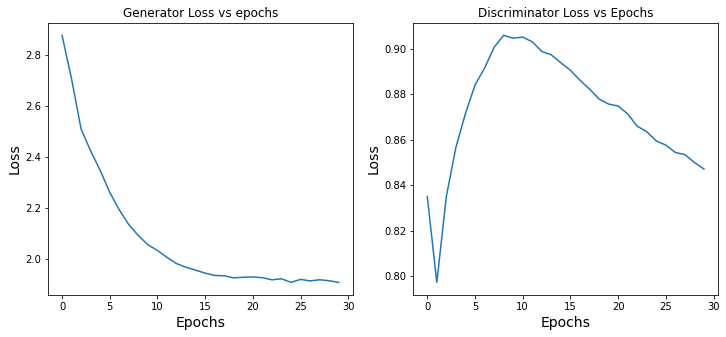

In [ ]:
dcgan.draw_losses_per_epoch_graphic()

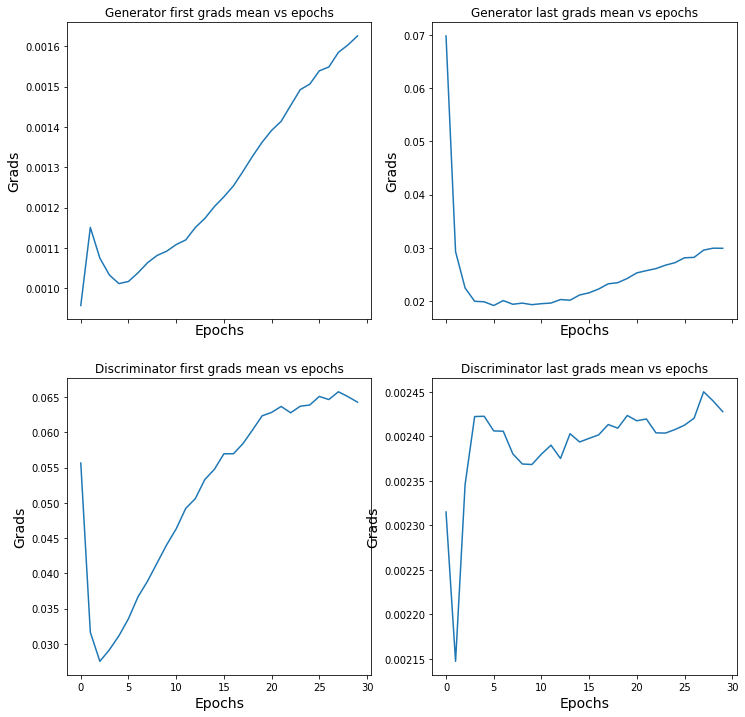

In [ ]:
dcgan.draw_grads_per_epoch_graphic()

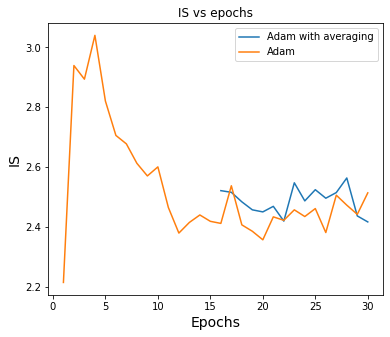

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(15)+16)]
axes.plot(x1, dcgan.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(30)+1)]
axes.plot(x2, dcgan.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

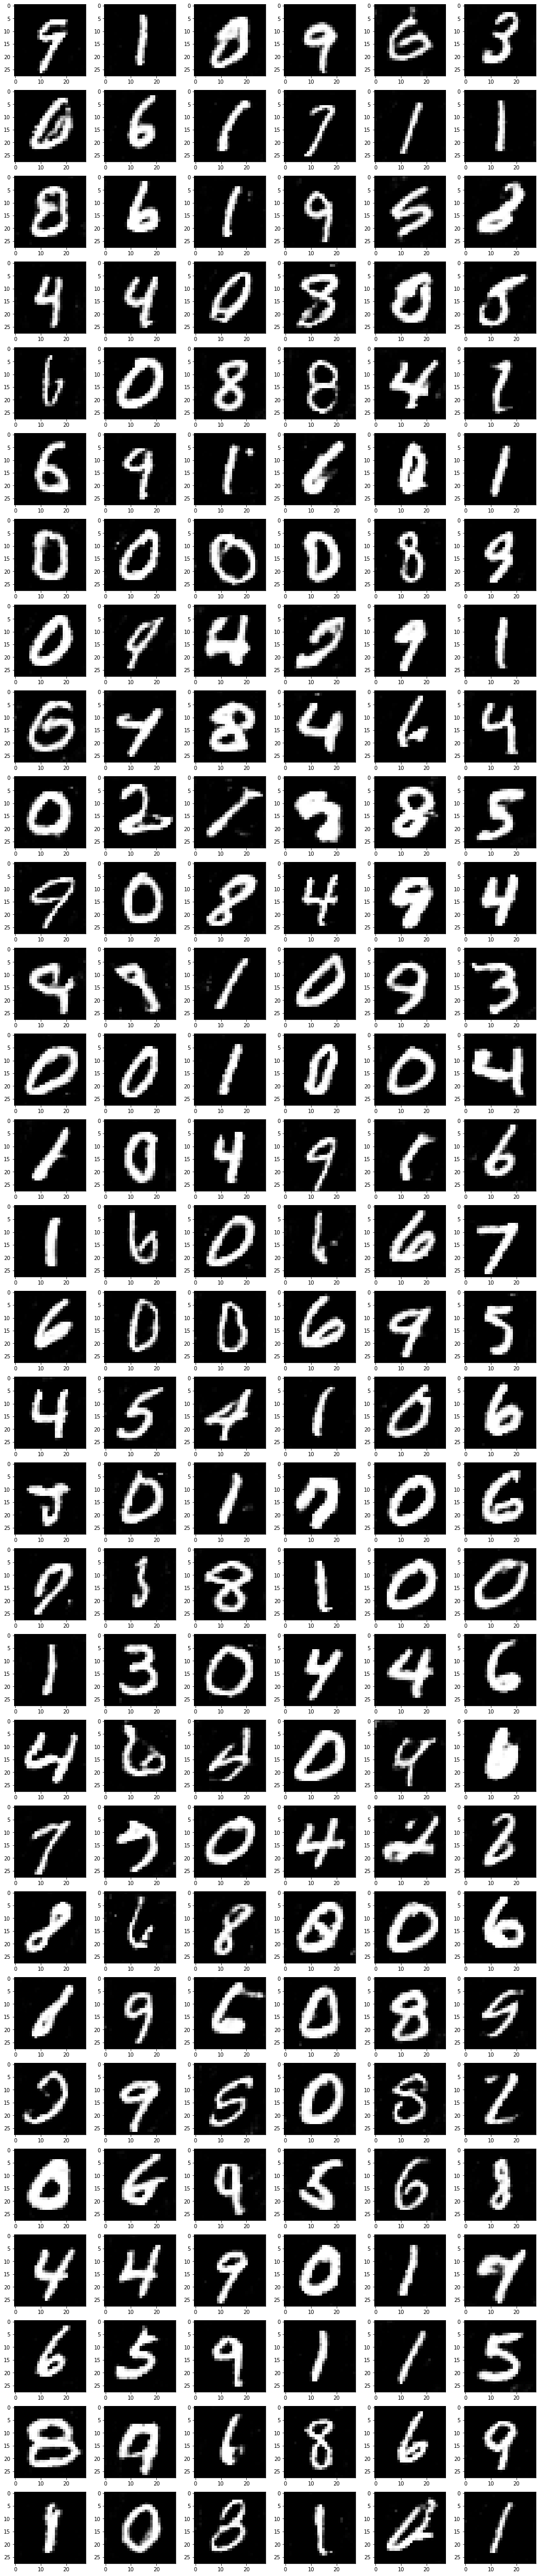

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6)

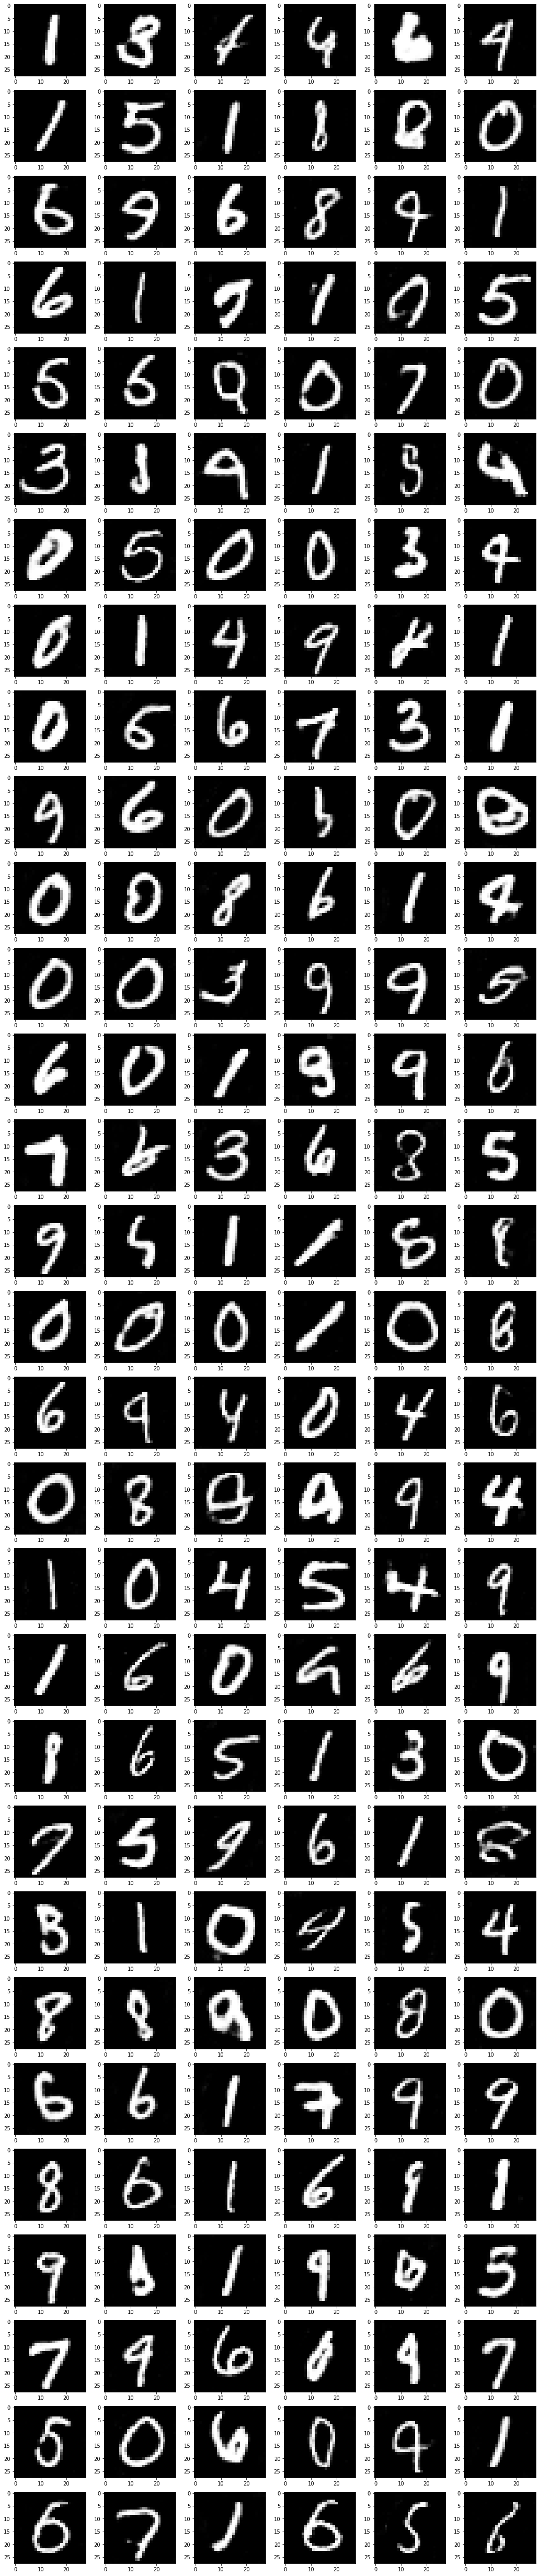

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6, is_from_gen_avr=True)

**OptimisticAdam**

In [ ]:
dcgan = DCGAN(OptimisticAdam(learning_rate=0.0002, beta_1=0.5), x_train, y_train, batch_size=64, use_averaging=False,
                path='/content/drive/My Drive/Univ/Final models/Saved models/DCGAN OptimisticAdam/')
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
dcgan.use_averaging = True
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
dcgan.draw_losses_per_epoch_graphic()

In [ ]:
dcgan.draw_grads_per_epoch_graphic()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(15)+16)]
axes.plot(x1, dcgan.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(15)+1)]
axes.plot(x2, dcgan.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6)

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6, is_from_gen_avr=True)

**ExtraAdam**

In [ ]:
dcgan = DCGAN(ExtraAdam(learning_rate=0.0002, beta_1=0.5), x_train, y_train, batch_size=128, use_averaging=False,
                path='/content/drive/My Drive/Univ/Final models/Saved models/DCGAN extra Adam/')
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
dcgan.use_averaging = True
t0 = time.clock()
dcgan.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
dcgan.draw_losses_per_epoch_graphic()

In [ ]:
dcgan.draw_grads_per_epoch_graphic()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(15)+16)]
axes.plot(x1, dcgan.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(15)+1)]
axes.plot(x2, dcgan.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6)

In [ ]:
dcgan.draw_generated_images(rows=30, cols=6, is_from_gen_avr=True)